## MOM025, WOMBAT, PI winds

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.0


In [4]:
CntrlDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z/'
PIDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/'

ExpDirs=[CntrlDir, PIDir]
print ExpDirs

['/g/data1/v45/pas561/mom/archive/wombat_jun16z/', '/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/']


In [58]:
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

#ty=ff.ty_trans_rho*msk*-1

(1080, 1440)


In [88]:
#Calc x_trans ACC streamlines
nc = Dataset('/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/wombat_jun16z_pi.tx_trans.2020.nc', mode='r') # file handle, open in read only mode
xt_ocean = nc.variables['xu_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
cntrl_tx_trans = nc.variables['tx_trans'][:,:,:,:]
nc.close() # close the file

lat=yt_ocean

#only include the Atlantic
#cntrl_tx_trans=cntrl_tx_trans*msk*-1

print cntrl_tx_trans.shape
cntrl_psi_a=np.ma.sum(cntrl_tx_trans[0,:,:,:],axis=0)
print cntrl_psi_a.shape
cntrl_psi=np.ma.cumsum(cntrl_psi_a[:,:],axis=0)
print cntrl_psi.shape
#Doesn't this fail in the tripolar region? Yeah, but apparently it doesn't matter



(1, 50, 1080, 1440)
(1080, 1440)
(1080, 1440)


In [90]:
#now find DP transport to subtract for the NAtl psi - see Rong
#plot Drake Passage time series
#T=np.arange(50)
#print T.shape

# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

cntrl_dp = cntrl_psi[0:j1,i1:i2]
cntrl_dp_bar = np.mean(cntrl_dp,1)
cntrl_dp_ts = np.max(cntrl_dp_bar,0)
print cntrl_dp_ts

[239] [842] [850]
174.751098633


[-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.]
[  0  20  40  60  80 100 120 140 160 180]


Text(0,0.5,u'Transport (Sv)')

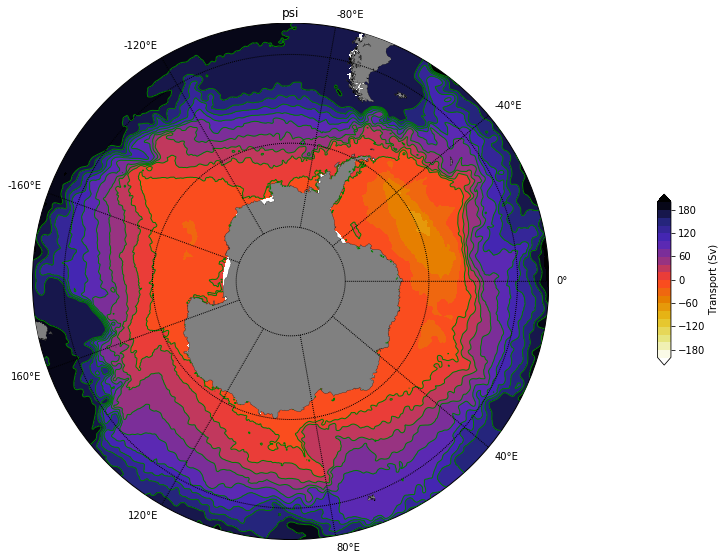

In [89]:
#plot ACC transport
levels = np.linspace(-200,200,21)
print levels

plt.subplot(1,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
print clev3
map.contour(X,Y,cntrl_psi,levels=clev3,colors='g',linewidths=1)
plt.title('psi')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')

Text(0.5,1,u'Control')

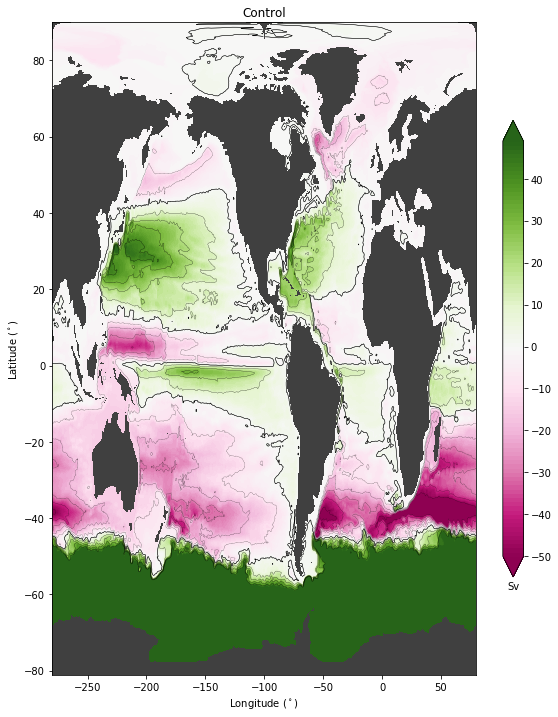

In [94]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-50,50,1)
clev2 = np.arange(-50,50,10)

t1=26
t2=30
#subtract the DP transport of 174Sv
#plt.subplot(211)
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,-cntrl_psi+cntrl_dp_ts,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(geolon_t,geolat_t,-cntrl_psi+cntrl_dp_ts,levels=clev2,colors='k',linewidths=0.25)
plt.contour(geolon_t,geolat_t,-cntrl_psi+cntrl_dp_ts,levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.xlim([-75,85])
plt.title('Control')

In [8]:
#import netCDF4 as nc4
#ofile = nc4.Dataset('/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/wombat_pi.psi.2020.nc', 'a')

#var = ofile.variables['tx_trans']
#print var.shape
#print cntrl_psi.shape
#var[0,0,:,:] = cntrl_psi

#ofile.sync()
#ofile.close()

## Calc the GMOC from ty_trans_rho for forcing cases

In [ ]:
#pi_gmoc=np.zeros((50,potrho.shape[0],yt_ocean.shape[0]))

Ocean_File = os.path.join(CntrlDir,'output*/ocean__*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans_rho.shape

#cn_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

#print cn_gmoc.shape

#of=os.path.join(CntrlDir,'cntrlwombat_gmocs.npy')
#a=np.save(of,cn_gmoc)

In [7]:
#Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
#print Ocean_File
#ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
#print ff.ty_trans_rho.shape

#pi_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

#print pi_gmoc.shape

#of=os.path.join(PIDir,'piwombat_gmocs.npy')
#a=np.save(of,pi_gmoc)


In [5]:
of=os.path.join(PIDir,'piwombat_gmocs.npy')
pi_gmoc=np.load(of)
print pi_gmoc.shape

of=os.path.join(CntrlDir,'cntrlwombat_gmocs.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape


(50, 80, 1080)
(50, 80, 1080)


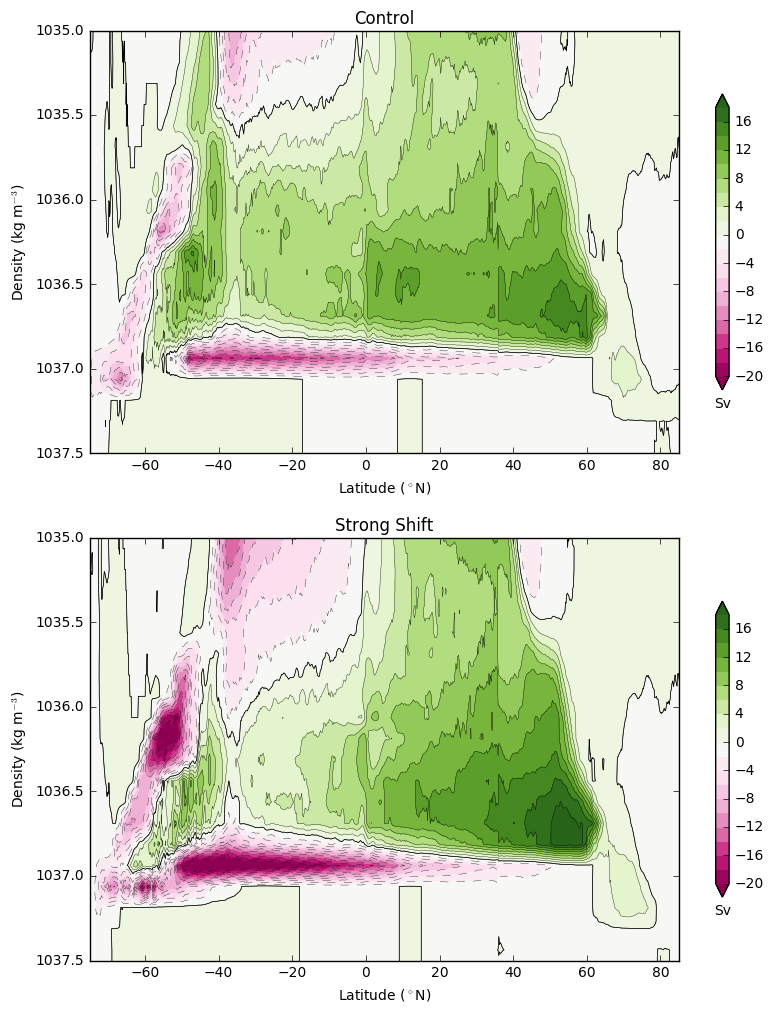

In [6]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=26
t2=30

plt.subplot(211)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Control')

plt.subplot(212)
plt.contourf(yu_ocean,potrho,np.mean(pi_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Strong Shift')



In [6]:
print potrho
print potrho[70]
j1 = 230
j2=235
print yt_ocean[j1:j2]

j1 = 130
j2=135
print yt_ocean[j1:j2]

j1 = 370
j2=375
print yt_ocean[j1:j2]
print potrho[65]

j1 = 600
j2=610
print yt_ocean[j1:j2]

j1 = 765
j2=770
print yt_ocean[j1:j2]
print potrho[68]



[ 1028.0625  1028.1875  1028.3125  1028.4375  1028.5625  1028.6875
  1028.8125  1028.9375  1029.0625  1029.1875  1029.3125  1029.4375
  1029.5625  1029.6875  1029.8125  1029.9375  1030.0625  1030.1875
  1030.3125  1030.4375  1030.5625  1030.6875  1030.8125  1030.9375
  1031.0625  1031.1875  1031.3125  1031.4375  1031.5625  1031.6875
  1031.8125  1031.9375  1032.0625  1032.1875  1032.3125  1032.4375
  1032.5625  1032.6875  1032.8125  1032.9375  1033.0625  1033.1875
  1033.3125  1033.4375  1033.5625  1033.6875  1033.8125  1033.9375
  1034.0625  1034.1875  1034.3125  1034.4375  1034.5625  1034.6875
  1034.8125  1034.9375  1035.0625  1035.1875  1035.3125  1035.4375
  1035.5625  1035.6875  1035.8125  1035.9375  1036.0625  1036.1875
  1036.3125  1036.4375  1036.5625  1036.6875  1036.8125  1036.9375
  1037.0625  1037.1875  1037.3125  1037.4375  1037.5625  1037.6875
  1037.8125  1037.9375]
1036.8125
[-55.42352179 -55.28138944 -55.13874852 -54.9955939  -54.8519288 ]
[-67.34918424 -67.24358565 -

(50,)
[-55.42352179 -55.28138944 -55.13874852 -54.9955939  -54.8519288 ]
1036.8125
(50, 80, 5)
(50,)
(51,)
[-67.34918424 -67.24358565 -67.13798706 -67.03238847 -66.92678988]
1036.8125
(50, 80, 5)
(50,)
(51,)
[-30.34766755 -30.13168517 -29.91523058 -29.69830307 -29.48090748]
1036.1875
(50, 80, 5)
(50,)
(51,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
1036.1875
(50, 80, 5)
(50,)
(51,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
1036.1875
(50, 80, 5)
(50,)
(51,)


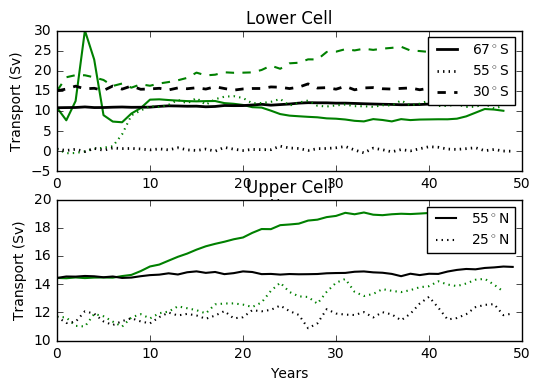

In [7]:
#plot time series of AABW
T=np.arange(50)
print T.shape

# average between j1 and j2
# do lower cell at 55S
j1 = 230
j2=235

print yt_ocean[j1:j2]
print potrho[70]

cntrl55_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55_psj.shape
cntrl55_psj_bar = np.mean(cntrl55_psj,2)
cntrl55_psj_ts = -np.min(cntrl55_psj_bar[:,70:],1)
print cntrl55_psj_ts.shape

pi55_psj = pi_gmoc[:,:,j1:j2]
pi55_psj_bar = np.mean(pi55_psj,2)
pi55_psj_ts = -np.min(pi55_psj_bar[:,70:],1)
pi55_psj_ts = np.insert(pi55_psj_ts,0,cntrl55_psj_ts[0])
print pi55_psj_ts.shape

# do lower cell at 67S
j1 = 130
j2=135

print yt_ocean[j1:j2]
print potrho[70]

cntrl67_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl67_psj.shape
cntrl67_psj_bar = np.mean(cntrl67_psj,2)
cntrl67_psj_ts = -np.min(cntrl67_psj_bar[:,70:],1)
print cntrl67_psj_ts.shape

pi67_psj = pi_gmoc[:,:,j1:j2]
pi67_psj_bar = np.mean(pi67_psj,2)
pi67_psj_ts = -np.min(pi67_psj_bar[:,70:],1)
pi67_psj_ts = np.insert(pi67_psj_ts,0,cntrl67_psj_ts[0])
print pi67_psj_ts.shape

# do lower cell at 30S
j1 = 370
j2=375

print yt_ocean[j1:j2]
print potrho[65]

cntrl30_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl30_psj.shape
cntrl30_psj_bar = np.mean(cntrl30_psj,2)
cntrl30_psj_ts = -np.min(cntrl30_psj_bar[:,65:],1)
print cntrl30_psj_ts.shape

pi30_psj = pi_gmoc[:,:,j1:j2]
pi30_psj_bar = np.mean(pi30_psj,2)
pi30_psj_ts = -np.min(pi30_psj_bar[:,65:],1)
pi30_psj_ts = np.insert(pi30_psj_ts,0,cntrl30_psj_ts[0])
print pi30_psj_ts.shape


plt.subplot(211)
plt.plot(pi67_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl67_psj_ts,linestyle='-',color='k',label='67$^\circ$S',linewidth=2)
plt.plot(pi55_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl55_psj_ts,linestyle=':',color='k',label='55$^\circ$S',linewidth=2)
plt.plot(pi30_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl30_psj_ts,linestyle='--',color='k',label='30$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Lower Cell')
plt.legend(fontsize=10)

#do nh upper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print potrho[65]

cntrl55N_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,68:],1)
print cntrl55N_psj_ts.shape

pi55N_psj = pi_gmoc[:,:,j1:j2]
pi55N_psj_bar = np.mean(pi55N_psj,2)
pi55N_psj_ts = np.max(pi55N_psj_bar[:,68:],1)
pi55N_psj_ts = np.insert(pi55N_psj_ts,0,cntrl55N_psj_ts[0])
print pi55N_psj_ts.shape


#do nh upper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print potrho[65]

cntrl25N_psj = cntrl_gmoc[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,68:],1)
print cntrl25N_psj_ts.shape

pi25N_psj = pi_gmoc[:,:,j1:j2]
pi25N_psj_bar = np.mean(pi25N_psj,2)
pi25N_psj_ts = np.max(pi25N_psj_bar[:,68:],1)
pi25N_psj_ts = np.insert(pi25N_psj_ts,0,cntrl25N_psj_ts[0])
print pi25N_psj_ts.shape

plt.subplot(212)
plt.plot(pi55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(pi25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Upper Cell')
plt.legend(fontsize=10)


In [ ]:
#calculate the Atl MOCs
#load mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

#calculate the AMOC for CNTRL in rho space
Ocean_File = os.path.join(CntrlDir,'output*/ocean__*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans_rho.shape

ty=ff.ty_trans_rho*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
amoc=ty[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print amoc.shape

of=os.path.join(CntrlDir,'cntrlwombat_amoc_rho.npy')
a=np.save(of,amoc)


#do in zspace
Ocean_File = os.path.join(CntrlDir,'output*/ocean__*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans.shape

ty=ff.ty_trans*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(CntrlDir,'cntrlwombat_amoc_z.npy')
a=np.save(of,amoc)

In [ ]:


#calculate the AMOC for PI in rho space
Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans_rho.shape

ty=ff.ty_trans_rho*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
print amoc.shape

of=os.path.join(PIDir,'piwombat_amoc_rho.npy')
a=np.save(of,amoc)

#do in zspace
Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans.shape
ty=ff.ty_trans*msk*-1
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(PIDir,'piwombat_amoc_z.npy')
a=np.save(of,amoc)





In [5]:
of=os.path.join(PIDir,'piwombat_amoc_z.npy')
pi_amoc_z=np.load(of)
print pi_amoc_z.shape

of=os.path.join(CntrlDir,'cntrlwombat_amoc_z.npy')
cntrl_amoc_z=np.load(of)
print cntrl_amoc_z.shape

of=os.path.join(PIDir,'piwombat_amoc_rho.npy')
pi_amoc_rho=np.load(of)
print pi_amoc_rho.shape

of=os.path.join(CntrlDir,'cntrlwombat_amoc_rho.npy')
cntrl_amoc_rho=np.load(of)
print cntrl_amoc_rho.shape

(50, 50, 1080)
(50, 50, 1080)
(50, 80, 1080)
(50, 80, 1080)


Text(0.5,1,u'Strong Shift')

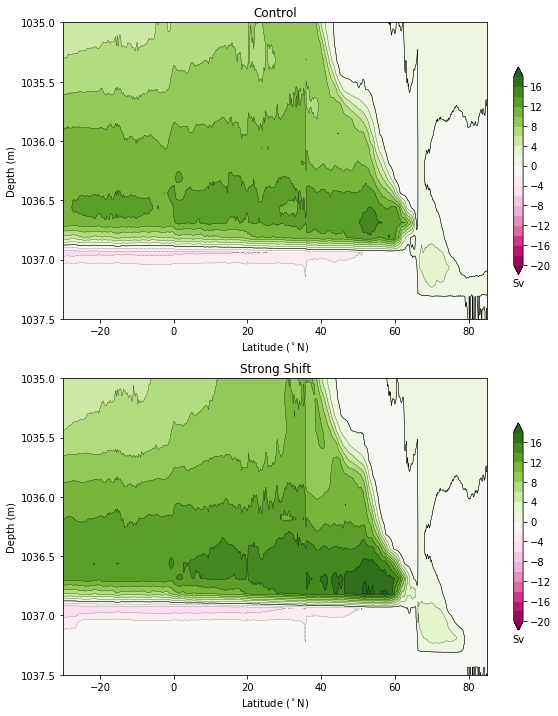

In [7]:
#Amoc in density space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=40
t2=50

plt.subplot(211)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Control')

plt.subplot(212)
plt.contourf(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Strong Shift')



[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]
0
2
4
6
8
10
12
14
16
18
20
22


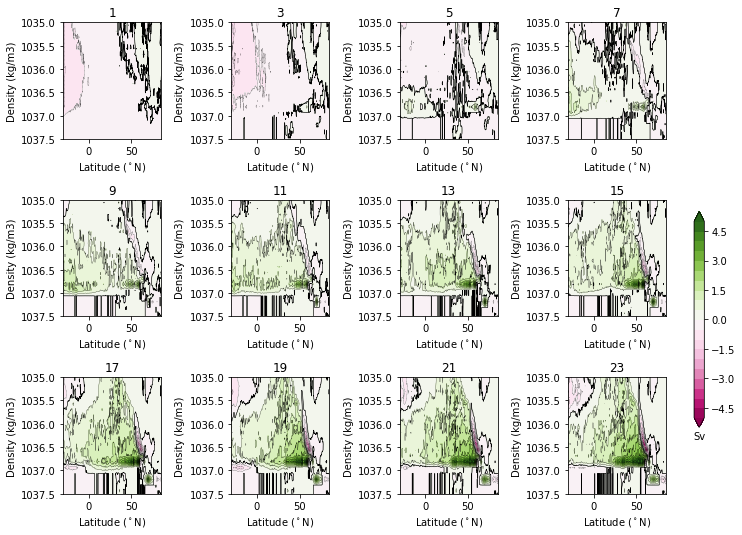

In [35]:
#plot Amoc Anomalies in density space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

t1=40
t2=50

clev = np.arange(-20,20,2)

#plt.subplot(541)
#plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
##cb=plt.colorbar(orientation='vertical',shrink = 0.7)
##cb.ax.set_xlabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$N)')
#plt.xlim([-30,85])
#plt.title('Control')

clev = np.arange(-5,5.5,0.5)
print clev

yrs=np.arange(1,24,1)

ii=0
for yr in range(0,24,2):
    
    print yr
    plt.subplot(5,4,ii+1)
    p1=plt.contourf(yu_ocean,potrho,np.mean(pi_amoc_rho[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_rho[yr:yr+2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_rho[yr:yr+2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_rho[yr:yr+2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1035))
    plt.ylabel('Density (kg/m3)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-30,85])
                 
    plt.title(yrs[yr].astype('S4'))
    
    ii+=1
    
ax3 = plt.axes([1.02,0.5,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')
plt.tight_layout()

(50,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
1036.1875
(50, 80, 5)
(50, 80)
(50,)
(51,)
[ 35.58791037  35.79095887  35.99348842  36.19550076  36.39699177]
1036.1875
(50, 80, 5)
(50,)
(51,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
1036.1875
(50, 80, 5)
(50,)
(51,)


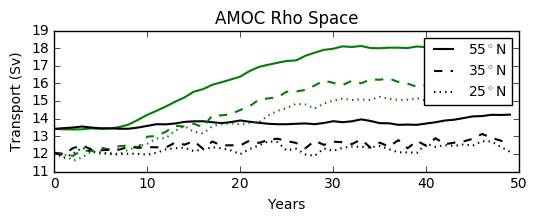

In [10]:
#plot time series of AMOC in rho space
T=np.arange(50)
print T.shape

#do nh upper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print potrho[65]
st_min=65

cntrl55N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
print cntrl55N_psj_bar.shape
rho_cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,st_min:],1)
print rho_cntrl55N_psj_ts.shape

pi55N_psj = pi_amoc_rho[:,:,j1:j2]
pi55N_psj_bar = np.mean(pi55N_psj,2)
pi55N_psj_ts = np.max(pi55N_psj_bar[:,st_min:],1)
rho_pi55N_psj_ts = np.insert(pi55N_psj_ts,0,rho_cntrl55N_psj_ts[0])
print rho_pi55N_psj_ts.shape

#do nh upper cell at 35N
j1 = 650
j2=655

print yt_ocean[j1:j2]
print potrho[st_min]

cntrl35N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl35N_psj.shape
cntrl35N_psj_bar = np.mean(cntrl35N_psj,2)
rho_cntrl35N_psj_ts = np.max(cntrl35N_psj_bar[:,st_min:],1)
print rho_cntrl35N_psj_ts.shape

pi35N_psj = pi_amoc_rho[:,:,j1:j2]
pi35N_psj_bar = np.mean(pi35N_psj,2)
pi35N_psj_ts = np.max(pi35N_psj_bar[:,st_min:],1)
rho_pi35N_psj_ts = np.insert(pi35N_psj_ts,0,rho_cntrl35N_psj_ts[0])
print rho_pi35N_psj_ts.shape


#do nh upper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print potrho[st_min]

cntrl25N_psj = cntrl_amoc_rho[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
rho_cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,st_min:],1)
print rho_cntrl25N_psj_ts.shape

pi25N_psj = pi_amoc_rho[:,:,j1:j2]
pi25N_psj_bar = np.mean(pi25N_psj,2)
pi25N_psj_ts = np.max(pi25N_psj_bar[:,st_min:],1)
rho_pi25N_psj_ts = np.insert(pi25N_psj_ts,0,rho_cntrl25N_psj_ts[0])
print rho_pi25N_psj_ts.shape

plt.subplot(211)
plt.plot(rho_pi55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(rho_cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(rho_pi35N_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(rho_cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(rho_pi25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(rho_cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('AMOC Rho Space')
plt.legend(fontsize=10)


(50,)
1030.6875
(50, 80, 1080)
(50, 1080)
[-8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.
 -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5]
1036.1875
(50, 80, 1080)
(50, 1080)


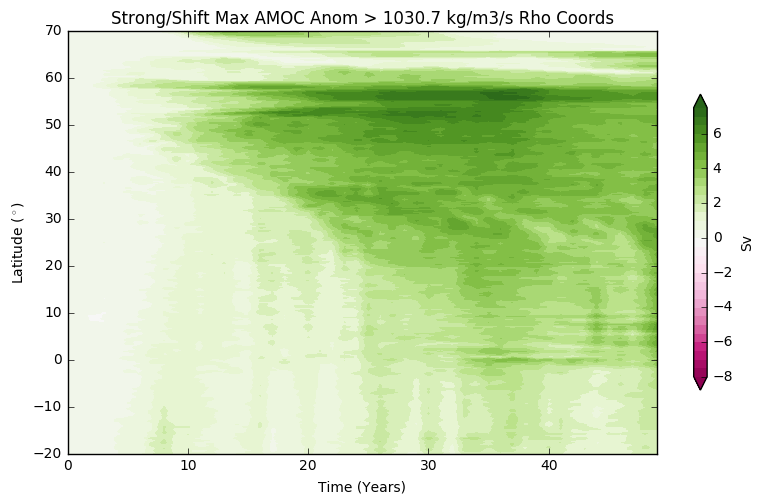

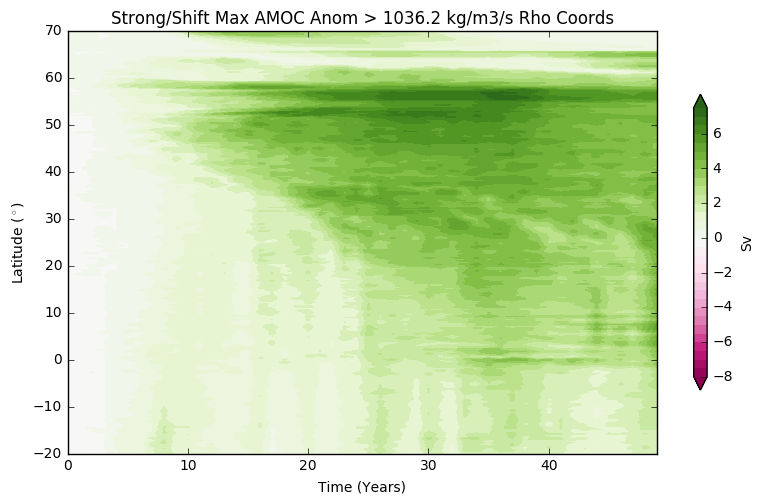

In [11]:
#AMOC Hovmoeller in rho space
time = np.arange(0,50,1)
print time.shape


print potrho[21]
st_min=21

#a=np.mean(cntrl_amoc_rho[0:4,:,:],axis=0)
#print 'a', a.shape

pi_amoc_rho_anom= pi_amoc_rho[:,:,:] - cntrl_amoc_rho[:,:,:]
print pi_amoc_rho_anom.shape

pi_amoc_rho_anom_max = np.max(pi_amoc_rho_anom[:,st_min:,:],1)
print pi_amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-8,8,.5)
print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,pi_amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
plt.title('Strong/Shift Max AMOC Anom > 1030.7 kg/m3/s Rho Coords')

print potrho[65]
st_min=65

#a=np.mean(cntrl_amoc_rho[0:4,:,:],axis=0)
#print 'a', a.shape

pi_amoc_rho_anom= pi_amoc_rho[:,:,:] - cntrl_amoc_rho[:,:,:]
print pi_amoc_rho_anom.shape

pi_amoc_rho_anom_max = np.max(pi_amoc_rho_anom[:,st_min:,:],1)
print pi_amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


plt.subplot(212)
plt.contourf(time,yu_ocean,pi_amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
plt.title('Strong/Shift Max AMOC Anom > 1036.2 kg/m3/s Rho Coords')

In [ ]:
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
matplotlib.use("Agg")
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='WOMBAT PI AMOC RHO Anom', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2, metadata=metadata)

clev = np.arange(-5,5.5,0.5)

fig = plt.figure()

with writer.saving(fig, "wombat_pi_amoc_rho.mp4", 100):
    for yr in range(0,50):
    
        print yr
        plt.contourf(yu_ocean,potrho,pi_amoc_rho[yr,:,:]-cntrl_amoc_rho[yr,:,:],cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('Sv')
        plt.contour(yu_ocean,potrho,pi_amoc_rho[yr,:,:]-cntrl_amoc_rho[yr,:,:],levels=clev,colors='k',linewidths=0.25)
        plt.contour(yu_ocean,potrho,pi_amoc_rho[yr,:,:]-cntrl_amoc_rho[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
        plt.gca().invert_yaxis()
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((1037.5,1035))
        plt.ylabel('Density (kg/m3)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.xlim([-30,85])
                 
        plt.title('Year ' + str(yr))
        plt.tight_layout()
        writer.grab_frame()
        plt.clf()
        


In [32]:
print cntrl_amoc_z.shape
print pi_amoc_z.shape

(50, 50, 1080)
(50, 50, 1080)


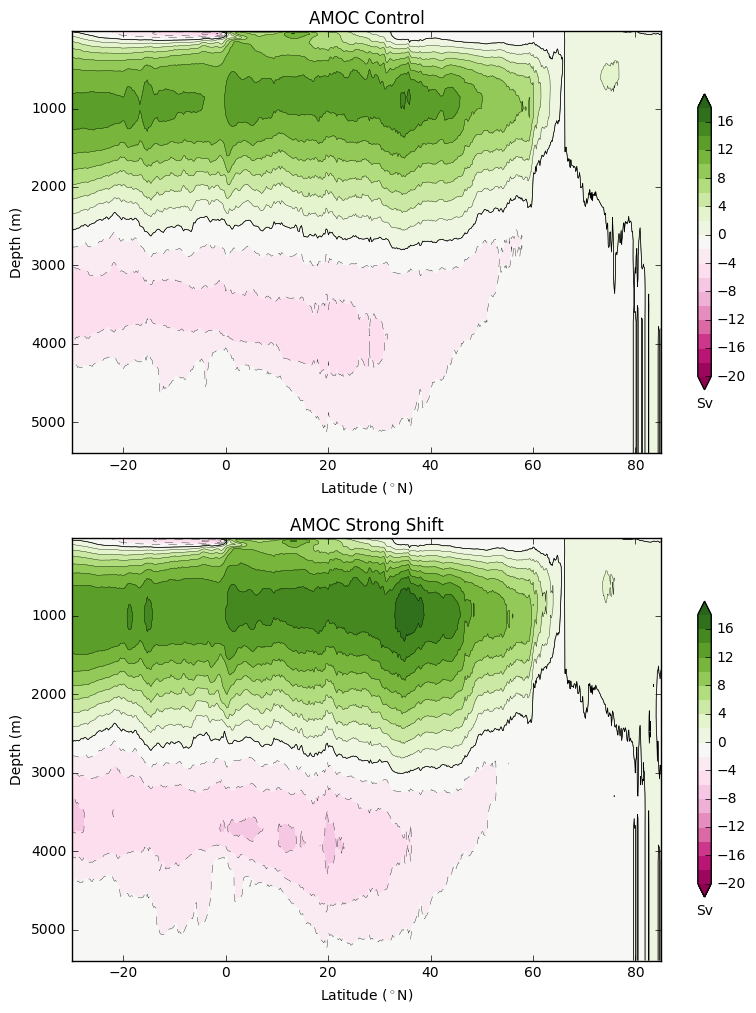

In [13]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


clev = np.arange(-20,20,2)

t1=40
t2=50

plt.subplot(211)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('AMOC Control')

plt.subplot(212)
plt.contourf(yu_ocean,st_ocean,np.mean(pi_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pi_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pi_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('AMOC Strong Shift')



[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]
0
2
4
6
8
10
12
14
16
18
20
22


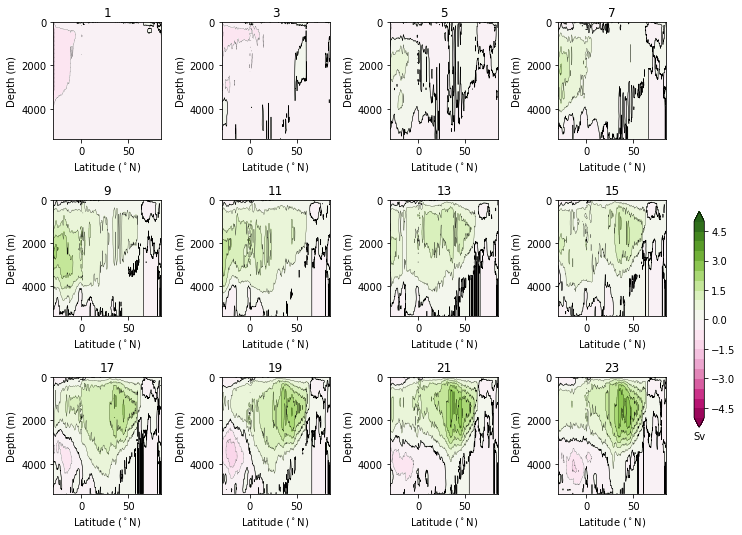

In [34]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

t1=40
t2=50

clev = np.arange(-20,20,2)

#plt.subplot(541)
#plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
##cb=plt.colorbar(orientation='vertical',shrink = 0.7)
##cb.ax.set_xlabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$N)')
#plt.xlim([-30,85])
#plt.title('Control')

clev = np.arange(-5,5.5,0.5)
print clev

yrs=np.arange(1,24,1)

ii=0
for yr in range(0,24,2):
    
    print yr
    plt.subplot(5,4,ii+1)
    p1=plt.contourf(yu_ocean,st_ocean,np.mean(pi_amoc_z[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_z[yr:yr+2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,st_ocean,np.mean(pi_amoc_z[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_z[yr:yr+2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,st_ocean,np.mean(pi_amoc_z[yr:yr+2,:,:],axis=0)-np.mean(cntrl_amoc_z[yr:yr+2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1035))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-30,85])
                 
    plt.title(yrs[yr].astype('S4'))
    
    ii+=1
    
ax3 = plt.axes([1.02,0.5,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')
plt.tight_layout()

(50,)
[ 55.42352179  55.56514233  55.70625623  55.84686025  55.9869596 ]
382.36505127
(50, 50, 5)
(50, 50)
(50,)
(51,)
[ 35.58791037  35.79095887  35.99348842  36.19550076  36.39699177]
382.36505127
(50, 50, 5)
(50,)
(51,)
[ 24.81117791  25.03789472  25.26419195  25.49006945  25.71552189
  25.94054921  26.1651461   26.38931259  26.61304344  26.83633873]
382.36505127
(50, 50, 5)
(50,)
(51,)


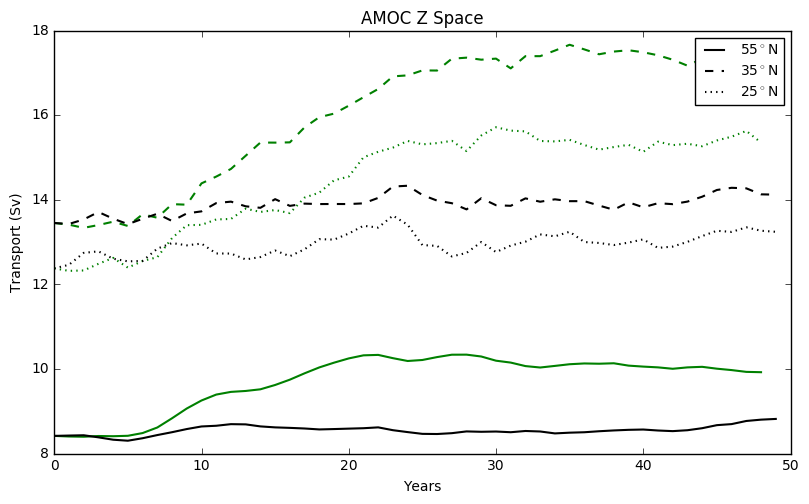

In [12]:
#plot time series of AMOC in z space
T=np.arange(50)
print T.shape

#do nh upper cell at 55N
j1 = 765
j2=770

print yt_ocean[j1:j2]
print st_ocean[21]
st_min=21

cntrl55N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl55N_psj_bar = np.mean(cntrl55N_psj,2)
print cntrl55N_psj_bar.shape
cntrl55N_psj_ts = np.max(cntrl55N_psj_bar[:,st_min:],1)
print cntrl55N_psj_ts.shape

pi55N_psj = pi_amoc_z[:,:,j1:j2]
pi55N_psj_bar = np.mean(pi55N_psj,2)
pi55N_psj_ts = np.max(pi55N_psj_bar[:,st_min:],1)
pi55N_psj_ts = np.insert(pi55N_psj_ts,0,cntrl55N_psj_ts[0])
print pi55N_psj_ts.shape

#do nh upper cell at 35N
j1 = 650
j2=655

print yt_ocean[j1:j2]
print st_ocean[st_min]

cntrl35N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl35N_psj.shape
cntrl35N_psj_bar = np.mean(cntrl35N_psj,2)
cntrl35N_psj_ts = np.max(cntrl35N_psj_bar[:,st_min:],1)
print cntrl35N_psj_ts.shape

pi35N_psj = pi_amoc_z[:,:,j1:j2]
pi35N_psj_bar = np.mean(pi35N_psj,2)
pi35N_psj_ts = np.max(pi35N_psj_bar[:,st_min:],1)
pi35N_psj_ts = np.insert(pi35N_psj_ts,0,cntrl35N_psj_ts[0])
print pi35N_psj_ts.shape


#do nh upper cell at 25N
j1 = 600
j2=610

print yt_ocean[j1:j2]
print st_ocean[st_min]

cntrl25N_psj = cntrl_amoc_z[:,:,j1:j2]
print cntrl55N_psj.shape
cntrl25N_psj_bar = np.mean(cntrl25N_psj,2)
cntrl25N_psj_ts = np.max(cntrl25N_psj_bar[:,st_min:],1)
print cntrl25N_psj_ts.shape

pi25N_psj = pi_amoc_z[:,:,j1:j2]
pi25N_psj_bar = np.mean(pi25N_psj,2)
pi25N_psj_ts = np.max(pi25N_psj_bar[:,st_min:],1)
pi25N_psj_ts = np.insert(pi25N_psj_ts,0,cntrl25N_psj_ts[0])
print pi25N_psj_ts.shape

plt.subplot(211)
plt.plot(pi55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(pi35N_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(pi25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('AMOC Z Space')
plt.legend(fontsize=10)


(50,)
110.096153259
(50, 50, 1080)
(50, 1080)
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5]
728.692077637
(50, 50, 1080)
(50, 1080)


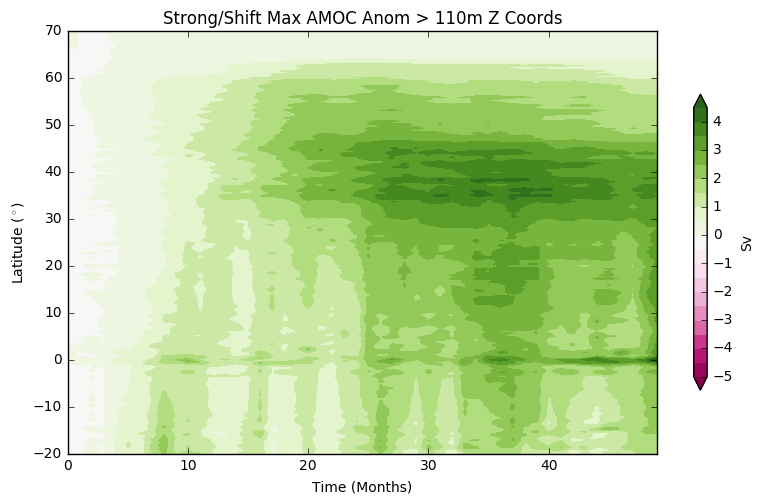

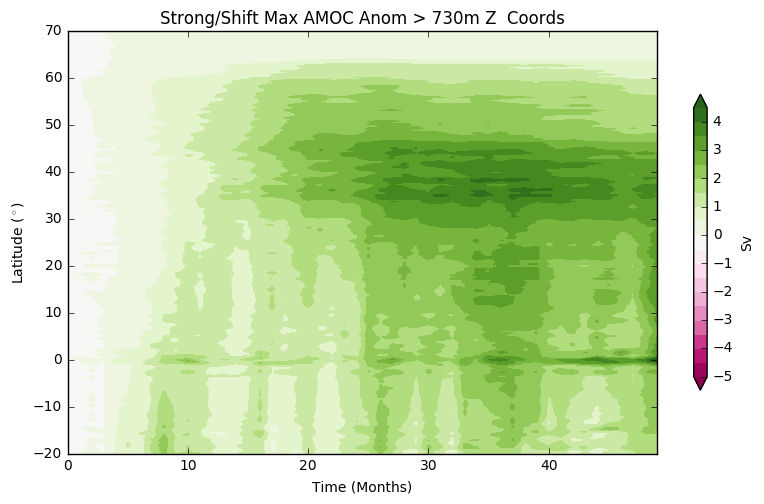

In [13]:
#Hovmoeller in z space
time = np.arange(0,50,1)
print time.shape


print st_ocean[10]
st_min=10


pi_amoc_z_anom= pi_amoc_z[:,:,:] - cntrl_amoc_z[:,:,:]
print pi_amoc_z_anom.shape

pi_amoc_z_anom_max = np.max(pi_amoc_z_anom[:,st_min:,:],1)
print pi_amoc_z_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-5,5,.5)
print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,pi_amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
plt.title('Strong/Shift Max AMOC Anom > 110m Z Coords')

print st_ocean[25]
st_min=25


pi_amoc_z_anom= pi_amoc_z[:,:,:] - cntrl_amoc_z[:,:,:]
print pi_amoc_z_anom.shape

pi_amoc_z_anom_max = np.max(pi_amoc_z_anom[:,st_min:,:],1)
print pi_amoc_z_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


plt.subplot(212)
plt.contourf(time,yu_ocean,pi_amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
plt.title('Strong/Shift Max AMOC Anom > 730m Z  Coords')

In [14]:
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
matplotlib.use("Agg")
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='WOMBAT PI AMOC Z Anom', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2, metadata=metadata)

clev = np.arange(-5,5.5,0.5)

fig = plt.figure()

with writer.saving(fig, "wombat_pi_amoc_z.mp4", 100):
    for yr in range(0,50):
    
        print yr
        plt.contourf(yu_ocean,st_ocean,pi_amoc_z[yr,:,:]-cntrl_amoc_z[yr,:,:],cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('Sv')
        plt.contour(yu_ocean,st_ocean,pi_amoc_z[yr,:,:]-cntrl_amoc_z[yr,:,:],levels=clev,colors='k',linewidths=0.25)
        plt.contour(yu_ocean,st_ocean,pi_amoc_z[yr,:,:]-cntrl_amoc_z[yr,:,:],levels=[0.0,],colors='k',linewidths=0.5)
        plt.gca().invert_yaxis()
        plt.gca().yaxis.set_major_formatter(x_formatter)
        #plt.ylim((1037.5,1035))
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.xlim([-30,85])
                 
        plt.title('Year ' + str(yr))
        plt.tight_layout()
        writer.grab_frame()
        plt.clf()
        


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/traitlets/config/applic

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [18]:
#calc barotropic stream function
#Does this fail in the tripolar region?
#also fails due to memory errors
#also fails for unknown reasons in NH ... something is fucked.

#problem with Time vs time dimensions

#Ocean_File = os.path.join(CntrlDir,'output197*/ocean__*.nc')
Ocean_File = os.path.join(CntrlDir,'wombat_cntrl.tx_trans.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tx_trans.shape
cn=ff.tx_trans[11:20,:,:,:].sum('st_ocean').cumsum('yt_ocean')
print cn.shape
of=os.path.join(CntrlDir,'cntrlwombat_psi_1981to1989.npy')
a=np.save(of,cn)


/g/data1/v45/pas561/mom/archive/wombat_jun16z/wombat_cntrl.tx_trans.nc
(50, 50, 1080, 1440)
(9, 1080, 1440)


In [20]:
of=os.path.join(CntrlDir,'cntrlwombat_psi_1970s1980.npy')
cn1=np.load(of)
print cn1.shape
of=os.path.join(CntrlDir,'cntrlwombat_psi_1981to1989.npy')
cn2=np.load(of)
print cn2.shape
of=os.path.join(CntrlDir,'cntrlwombat_psi_1990s.npy')
cn3=np.load(of)
print cn3.shape
of=os.path.join(CntrlDir,'cntrlwombat_psi_2000s.npy')
cn4=np.load(of)
print cn4.shape

cn = np.concatenate((cn1,cn2),axis=0)
print cn.shape
cn = np.concatenate((cn,cn3),axis=0)
print cn.shape
cn = np.concatenate((cn,cn4),axis=0)
print cn.shape

of=os.path.join(CntrlDir,'cntrlwombat_psi_1971to2020.npy')
a=np.save(of,cn)



(10, 1080, 1440)
(9, 1080, 1440)
(10, 1080, 1440)
(21, 1080, 1440)
(19, 1080, 1440)
(29, 1080, 1440)
(50, 1080, 1440)


In [23]:
Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.tx_trans.shape

pi_psi=ff.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()
print pi_psi.shape

of=os.path.join(PIDir,'piwombat_psi.npy')
a=np.save(of,pi_psi)

/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_month_*.nc
(50, 50, 1080, 1440)
(50, 1080, 1440)


In [24]:
of=os.path.join(PIDir,'piwombat_psi.npy')
pi_psi=np.load(of)
print pi_psi.shape

of=os.path.join(CntrlDir,'cntrlwombat_psi_1971to2020.npy')
cntrl_psi=np.load(of)
print cntrl_psi.shape

#now find DP transport to subtract for the NAtl psi - see Rong

# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

cntrl_dp = cntrl_psi[:,0:j1,i1:i2]
cntrl_dp_bar = np.mean(cntrl_dp,2)
cntrl_dp_ts = np.max(cntrl_dp_bar,1)
print cntrl_dp_ts

pi_dp = pi_psi[:,0:j1,i1:i2]
pi_dp_bar = np.mean(pi_dp,2)
pi_dp_ts = np.max(pi_dp_bar,1)
print pi_dp_ts


(50, 1080, 1440)
(50, 1080, 1440)
[239] [843] [851]
[ 135.0605197   135.25220133  134.9814252   135.25664338  134.42283377
  135.27376619  134.56075994  135.23631824  134.64393419  134.6762421
  134.50622093  134.92756298  134.54800496  134.74412997  134.27149814
  134.3199192   134.36444119  134.24770055  134.01267919  134.01267919
  134.17865535  134.10227816  134.42428659  134.3165643   133.95455724
  134.27980252  133.97857942  134.37764809  133.48903813  134.39933779
  133.80282573  133.6872758   134.11084173  133.8222766   133.14580609
  134.09554085  133.4837567   133.02173029  133.41926491  133.67296045
  133.25857016  133.40183972  133.72560727  133.21382858  133.35069583
  133.21342212  132.87466606  133.24676508  132.90561872  132.80572066]
[ 143.76276176  145.3938438   148.73137452  154.3042063   159.48844433
  164.51227232  168.79052368  171.71007575  172.31092695  175.22100651
  176.43329401  177.25155166  176.64283685  176.36521717  176.14590362
  177.80902251  177.72000

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Text(0.5,1,u'(b) PI')

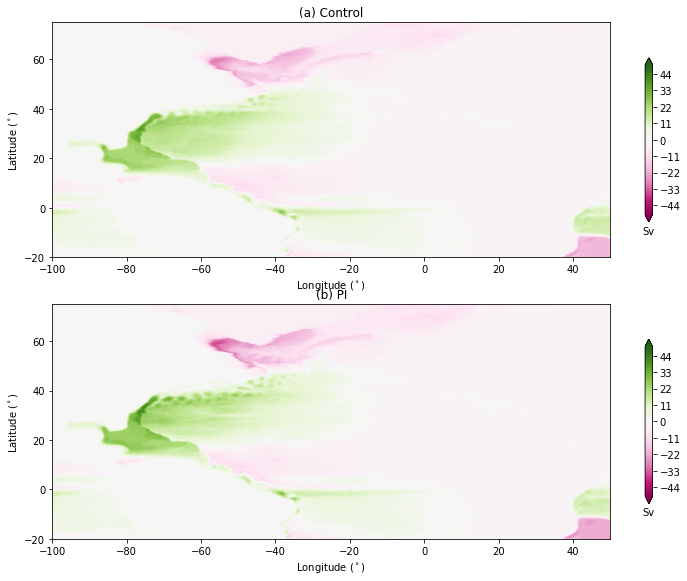

In [35]:
#plot NAtl Psi
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-50,51,1)
clev2 = np.arange(-50,60,10)

t1=10
t2=20

plt.subplot(211)#,axisbg='gray')
plt.gca().patch.set_color('.25')
#plt.contourf(geolon_t,geolat_t,-cntrl_psi[0,:,:]+cntrl_dp_ts[0], cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
plt.contourf(geolon_t,geolat_t,-np.ma.mean(cntrl_psi[t1:t2,:,:],axis=0)+np.mean(cntrl_dp_ts[t1:t2]), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#plt.contour(geolon_t,geolat_t,-np.ma.mean(cntrl_psi[t1:t2,:,:],axis=0)+np.mean(cntrl_dp_ts[t1:t2]),levels=clev2,colors='k',linewidths=0.25)
#plt.contour(geolon_t,geolat_t,-np.ma.mean(cntrl_psi[t1:t2,:,:],axis=0)+np.mean(cntrl_dp_ts[t1:t2]),levels=[0.0,],colors='k',linewidths=0.5)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(a) Control')

plt.subplot(212)#,axisbg='gray')
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,-pi_psi[20,:,:]+pi_dp_ts[20], cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#plt.contour(geolon_t,geolat_t,-np.ma.mean(pi_psi[t1:t2,:,:],axis=0)+np.mean(pi_dp_ts[t1:t2]),levels=clev2,colors='k',linewidths=0.25)
#plt.contour(geolon_t,geolat_t,-np.ma.mean(pi_psi[t1:t2,:,:],axis=0)+np.mean(pi_dp_ts[t1:t2]),levels=[0.0,],colors='k',linewidths=0.5)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(b) PI')


In [39]:
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
matplotlib.use("Agg")
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='WOMBAT PI NAtl PSI Z Anom', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2, metadata=metadata)

clev = np.arange(-3,3.1,0.1)

fig = plt.figure()

with writer.saving(fig, "wombat_natl_psi.mp4", 100):
    for yr in range(0,50):
    
        print yr
        plt.gca().patch.set_color('.25')
        plt.contourf(geolon_t,geolat_t,(-pi_psi[yr,:,:]+pi_dp_ts[yr])-(-cntrl_psi[yr,:,:]+cntrl_dp_ts[yr]), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
        cb = plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('Sv')
        #plt.contour(geolon_t,geolat_t,-np.ma.mean(pi_psi[t1:t2,:,:],axis=0)+np.mean(pi_dp_ts[t1:t2]),levels=clev2,colors='k',linewidths=0.25)
        #plt.contour(geolon_t,geolat_t,-np.ma.mean(pi_psi[t1:t2,:,:],axis=0)+np.mean(pi_dp_ts[t1:t2]),levels=[0.0,],colors='k',linewidths=0.5)
        plt.ylim((-20,75))
        plt.xlabel('Longitude ($^\circ$)')
        plt.ylabel('Latitude ($^\circ$)')
        plt.xlim([-100,50])

        plt.title('Year ' + str(yr))
        plt.tight_layout()
        writer.grab_frame()
        plt.clf()

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/traitlets/config/applic

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [31]:
#do mass transports (kg/s) 
Ocean_File = os.path.join(CntrlDir,'wombat_cntrl.tx_trans.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.tx_trans.shape

cn_tx10=ff.tx_trans[:,10,:,:].load()
cn_tx30=ff.tx_trans[:,30,:,:].load()

print cn_tx10.shape, cn_tx30.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z/wombat_cntrl.tx_trans.nc
(50, 50, 1080, 1440)


In [ ]:
print st_ocean[10]
print st_ocean[30]

In [30]:
Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.tx_trans.shape

pi_tx10=ff.tx_trans[:,10,:,:].load()
pi_tx30=ff.tx_trans[:,30,:,:].load()
print pi_tx10.shape, pi_tx30.shape




/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_month_*.nc
(50, 50, 1080, 1440)
(50, 1080, 1440) (50, 1080, 1440)


[ -3.00000000e-02  -2.75000000e-02  -2.50000000e-02  -2.25000000e-02
  -2.00000000e-02  -1.75000000e-02  -1.50000000e-02  -1.25000000e-02
  -1.00000000e-02  -7.50000000e-03  -5.00000000e-03  -2.50000000e-03
  -1.38777878e-17   2.50000000e-03   5.00000000e-03   7.50000000e-03
   1.00000000e-02   1.25000000e-02   1.50000000e-02   1.75000000e-02
   2.00000000e-02   2.25000000e-02   2.50000000e-02   2.75000000e-02
   3.00000000e-02]
[ -1.00000000e-01  -9.00000000e-02  -8.00000000e-02  -7.00000000e-02
  -6.00000000e-02  -5.00000000e-02  -4.00000000e-02  -3.00000000e-02
  -2.00000000e-02  -1.00000000e-02  -5.55111512e-17   1.00000000e-02
   2.00000000e-02   3.00000000e-02   4.00000000e-02   5.00000000e-02
   6.00000000e-02   7.00000000e-02   8.00000000e-02   9.00000000e-02
   1.00000000e-01]


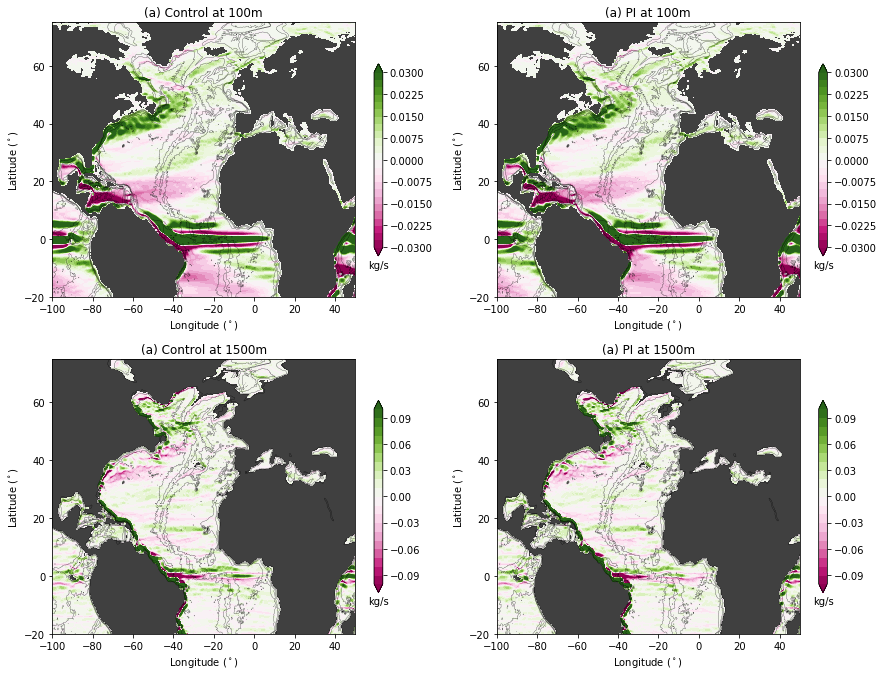

In [80]:
#plot NAtl Mass transports
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>-20)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-.03,.0325,.0025)
print clev

t1=10
t2=20

plt.subplot(221)#,axisbg='gray')
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,np.mean(cn_tx10[t1:t2,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/s')
clev3 = np.arange(0,5000,1000)
plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(a) Control at 100m')

plt.subplot(222)#,axisbg='gray')
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,np.mean(pi_tx10[t1:t2,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/s')
clev3 = np.arange(0,5000,1000)
plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(a) PI at 100m')


clev = np.arange(-.1,.11,.01)
print clev

plt.subplot(223)#,axisbg='gray')
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,np.mean(cn_tx30[t1:t2,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/s')
clev3 = np.arange(0,5000,1000)
plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(a) Control at 1500m')


plt.subplot(224)#,axisbg='gray')
plt.gca().patch.set_color('.25')
plt.contourf(geolon_t,geolat_t,np.mean(pi_tx30[t1:t2,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/s')
clev3 = np.arange(0,5000,1000)
plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
plt.ylim((-20,75))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-100,50])
plt.title('(a) PI at 1500m')

plt.tight_layout()


0
2
4
6
8
10
12
14
16
18
20
22


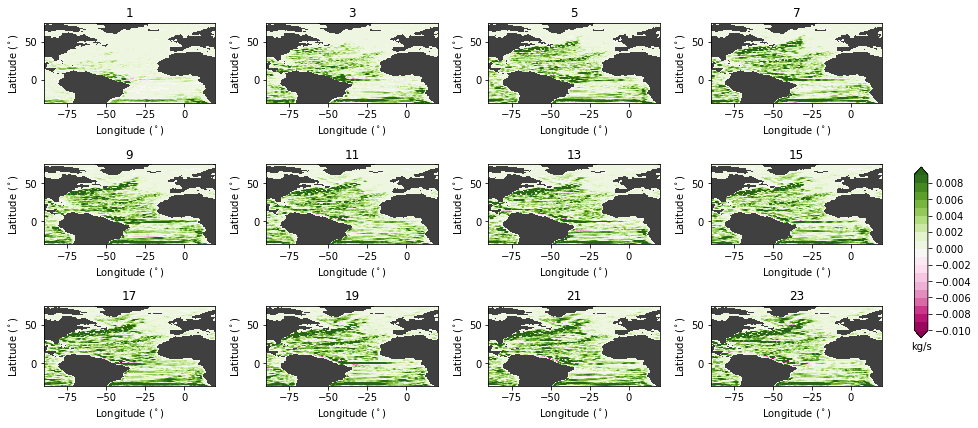

In [85]:
yrs=np.arange(1,24,1)

clev = np.arange(-.01,.01,.001)
#clev = np.arange(-100,105,5)

ii=0
for yr in range(0,24,2):
    
    #chg=(np.mean(pi_tx10[yr:yr+2,:,:],axis=0)-np.mean(cn_tx10[yr:yr+2,:,:],axis=0))/np.mean(cn_tx10[yr:yr+2,:,:],axis=0)*100
    chg=(np.mean(pi_tx10[yr:yr+2,:,:],axis=0)-np.mean(cn_tx10[yr:yr+2,:,:],axis=0))
    
    print yr
    plt.subplot(5,4,ii+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(geolon_t,geolat_t,chg, cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((-30,75))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.xlim([-90,20])
                 
    plt.title(yrs[yr].astype('S4'))
    
    ii+=1
    
ax3 = plt.axes([1.02,0.5,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('kg/s')
#cb.ax.set_xlabel('%')
plt.tight_layout()

0
2
4
6
8
10
12
14
16
18
20
22


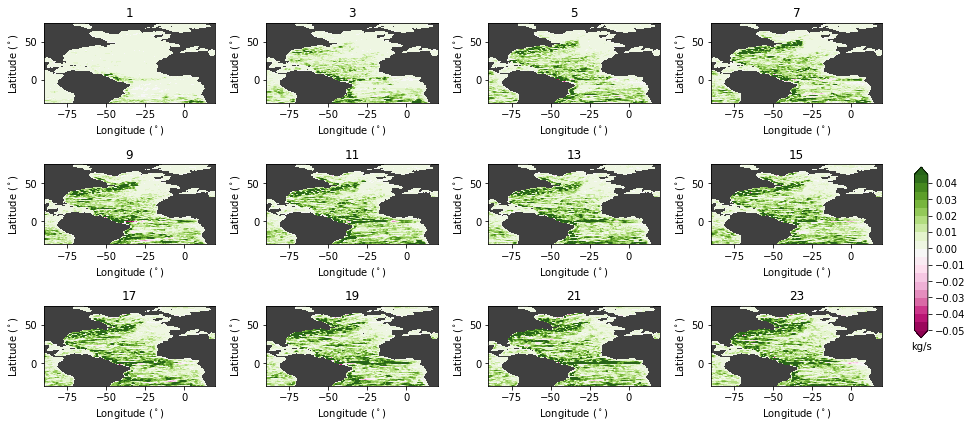

In [87]:
yrs=np.arange(1,24,1)

clev = np.arange(-.05,.05,.005)
#clev = np.arange(-100,105,5)

ii=0
for yr in range(0,24,2):
    #chg=(np.mean(pi_tx30[yr:yr+2,:,:],axis=0)-np.mean(cn_tx30[yr:yr+2,:,:],axis=0))/np.mean(cn_tx30[yr:yr+2,:,:],axis=0)*100
    chg=(np.mean(pi_tx30[yr:yr+2,:,:],axis=0)-np.mean(cn_tx30[yr:yr+2,:,:],axis=0))
  
    print yr
    plt.subplot(5,4,ii+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(geolon_t,geolat_t,chg, cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #plt.contour(geolon_t,geolat_t,ht,levels=clev3,colors='k',linewidths=0.25)
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((-30,75))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.xlim([-90,20])
                 
    plt.title(yrs[yr].astype('S4'))
    
    ii+=1
    
ax3 = plt.axes([1.02,0.5,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('kg/s')
#cb.ax.set_xlabel('%')
plt.tight_layout()

/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_month_*.nc
(50, 50, 1080, 1440)


In [36]:
#plot Atl rho profiles
Ocean_File = os.path.join(CntrlDir,'Tdim_output*/ocean__*7.nc')
print Ocean_File
cn1=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cn1.pot_rho_0.shape

Ocean_File = os.path.join(CntrlDir,'output*/ocean__*.nc')
print Ocean_File
cn2=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print cn2.pot_rho_0.shape

Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert.pot_rho_0.shape


/g/data1/v45/pas561/mom/archive/wombat_jun16z/Tdim_output*/ocean__*7.nc
(9, 50, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ocean__*.nc
(40, 50, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_month_*.nc
(50, 50, 1080, 1440)


In [44]:
#load ATL mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

jj=1020

cntrl=cn1.pot_rho_0[0:1,:,:,jj].mean('time').load()#*msk*-1
print cntrl.shape
#cntrl=np.ma.mean(cntrl,axis=2)
#this zonal average fails.
print cntrl.shape

pi=pert.pot_rho_0[0:1,:,:,jj].mean('Time').load()#*msk*-1
print pi.shape
#this zonal average fails.
#pi=np.ma.mean(pi,axis=2)
print pi.shape

(1080, 1440)
(50, 1080)
(50, 1080)
(50, 1080)
(50, 1080)


Text(0.5,1,u'Strong/Shift at 25E')

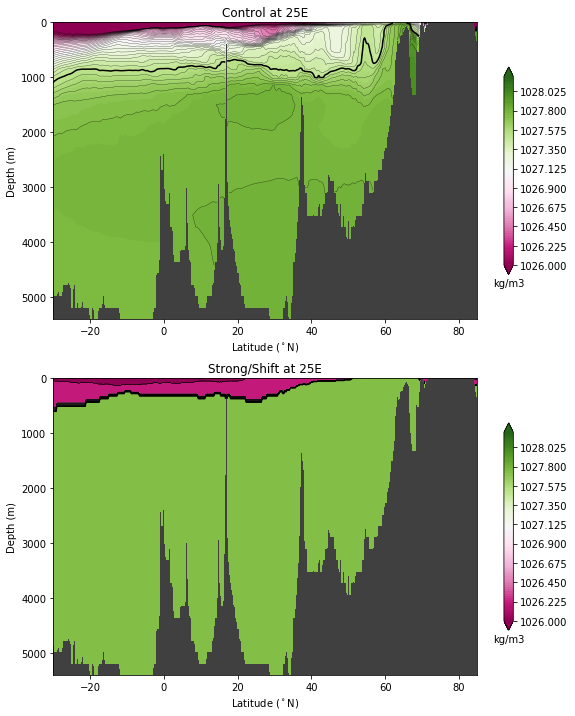

In [45]:

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(1026,1028.2,.025)
clev2 = np.arange(1026,1028.2,.05)

jj=1020

plt.subplot(211)
plt.gca().patch.set_color('.25')
plt.contourf(yt_ocean,st_ocean,cntrl,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
plt.contour(yt_ocean,st_ocean,cntrl,levels=clev2,colors='k',linewidths=0.25)
plt.contour(yt_ocean,st_ocean,cntrl,levels=[1027.5,],colors='k',linewidths=1.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Control at 25E')

plt.subplot(212)
plt.gca().patch.set_color('.25')
plt.contourf(yt_ocean,st_ocean,pi,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
plt.contour(yt_ocean,st_ocean,pi,levels=clev2,colors='k',linewidths=0.25)
plt.contour(yt_ocean,st_ocean,pi,levels=[1027.5,],colors='k',linewidths=1.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('Strong/Shift at 25E')



0
(50, 1080) (50, 1080)


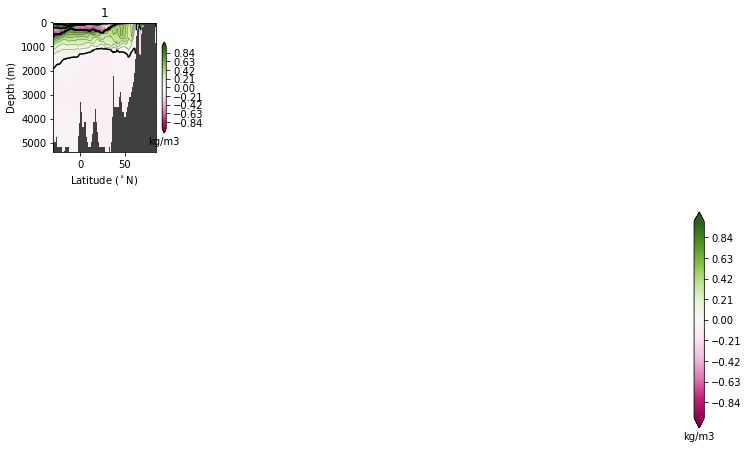

In [41]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-1,1.01,.01)
clev2 = np.arange(-1,1.1,.1)

jj=1020

yrs=np.arange(1,24,1)

ii=0
for yr in range(0,1,1):
    
    print yr
    
    if yr < 2:
        cntrl=cn1.pot_rho_0[0,:,:,jj].load()
    if yr < 10:
        cntrl=cn1.pot_rho_0[yr-1,:,:,jj].load()
    else:
        cntrl=cn2.pot_rho_0[yr-10,:,:,jj].load()
        print yr-10
    
    pi=pert.pot_rho_0[yr,:,:,jj].load()
    
    print cntrl.shape, pi.shape
    
    
    plt.subplot(5,4,ii+1)              
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(yt_ocean,st_ocean,pi-cntrl,cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    cb.ax.set_xlabel('kg/m3')
    plt.contour(yt_ocean,st_ocean,pi-cntrl,levels=clev2,colors='k',linewidths=0.25)
    plt.contour(yt_ocean,st_ocean,pi-cntrl,levels=[0.0,],colors='k',linewidths=1.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1035))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-30,85])
    #plt.title('Strong/Shift at 25E')
    plt.title(yrs[yr].astype('S4'))

        
    
    ii+=1
    
ax3 = plt.axes([1.02,0.5,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('kg/m3')
plt.tight_layout()

In [ ]:
Ocean_File = os.path.join(CntrlDir,'output201*/ocean_bgc_carbon*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.o2.shape
o2=ff.o2[-60:,:,:,:].mean('Time').load()
print o2.shape

of=os.path.join(CntrlDir,'cntrlwombat_o2_yrs46-50.npy')
a=np.save(of,o2)

Ocean_File = os.path.join(PIDir,'output201*/ocean_bgc_carbon*01.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.o2.shape
o2=ff.o2[-60:,:,:,:].mean('Time').load()
print o2.shape

of=os.path.join(PIDir,'piwombat_o2_yrs46-50.npy')
a=np.save(of,pi_o2)

(120, 50, 1080, 1440)


In [20]:
#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

print "o2 bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]
st_min=30
print st_ocean[st_min]

Ocean_File = os.path.join(CntrlDir,'output1971/ocean_bgc_carbon*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.o2.shape
nyf=ff.o2[:,:,:,:].mean('Time').load()
print nyf.shape




o2 bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [ 30.13168517] 89.947282327
1497.56188965
(12, 50, 1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


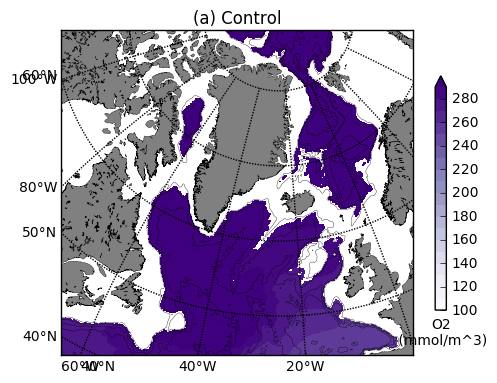

In [8]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(100,300,10)

plt.subplot(221)#,axisbg='gray')
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,nyf[st_min,jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('O2\n (mmol/m^3)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

plt.show()

In [5]:
#calculate the Atl BC tracers
#load mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

#calculate the 02 and DIC for CNTRL, zonal average in Atl
Ocean_File = os.path.join(CntrlDir,'output*/ocean_bgc_carbon*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.o2.shape

ty=ff.o2*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
zavg=ty[:,:,:,:].mean('xt_ocean').load()

print zavg.shape

of=os.path.join(CntrlDir,'cntrlwombat_Atl_zavg02.npy')
a=np.save(of,zavg)


ty=ff.dic*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
zavg=ty[:,:,:,:].mean('xt_ocean').load()

print zavg.shape

of=os.path.join(CntrlDir,'cntrlwombat_Atl_zavgDIC.npy')
a=np.save(of,zavg)

(1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ocean_bgc_carbon*.nc
(600, 50, 1080, 1440)
(600, 50, 1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(600, 50, 1080)
(600, 50, 1080, 1440)
(600, 50, 1080)


In [3]:
#calculate the Atl BGC tracers
#load mask
#-1 is Atl and Arctic, all else is 0 
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0

#calculate the 02 and DIC for PI, zonal average in Atl
Ocean_File = os.path.join(PIDir,'output*/ocean_bgc_carbon*01.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.o2.shape

ty=ff.o2*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
zavg=ty[:,:,:,:].mean('xt_ocean').load()

print zavg.shape

of=os.path.join(PIDir,'piwombat_Atl_zavg02.npy')
a=np.save(of,zavg)


ty=ff.dic*msk*-1
print ty.shape

#check masking
#plt.imshow(ty[9,60,:,:])
#plt.gca().invert_yaxis()
#plt.show()

#cn_amoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
zavg=ty[:,:,:,:].mean('xt_ocean').load()

print zavg.shape

of=os.path.join(PIDir,'piwombat_Atl_zavgDIC.npy')
a=np.save(of,zavg)

(1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_bgc_carbon*01.nc
(600, 50, 1080, 1440)
(600, 50, 1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(600, 50, 1080)
(600, 50, 1080, 1440)
(600, 50, 1080)


In [7]:
of=os.path.join(PIDir,'piwombat_Atl_zavg02.npy')
pi_o2=np.load(of)
print pi_o2.shape

of=os.path.join(CntrlDir,'cntrlwombat_Atl_zavg02.npy')
cntrl_o2=np.load(of)
print cntrl_o2.shape

(600, 50, 1080)
(600, 50, 1080)


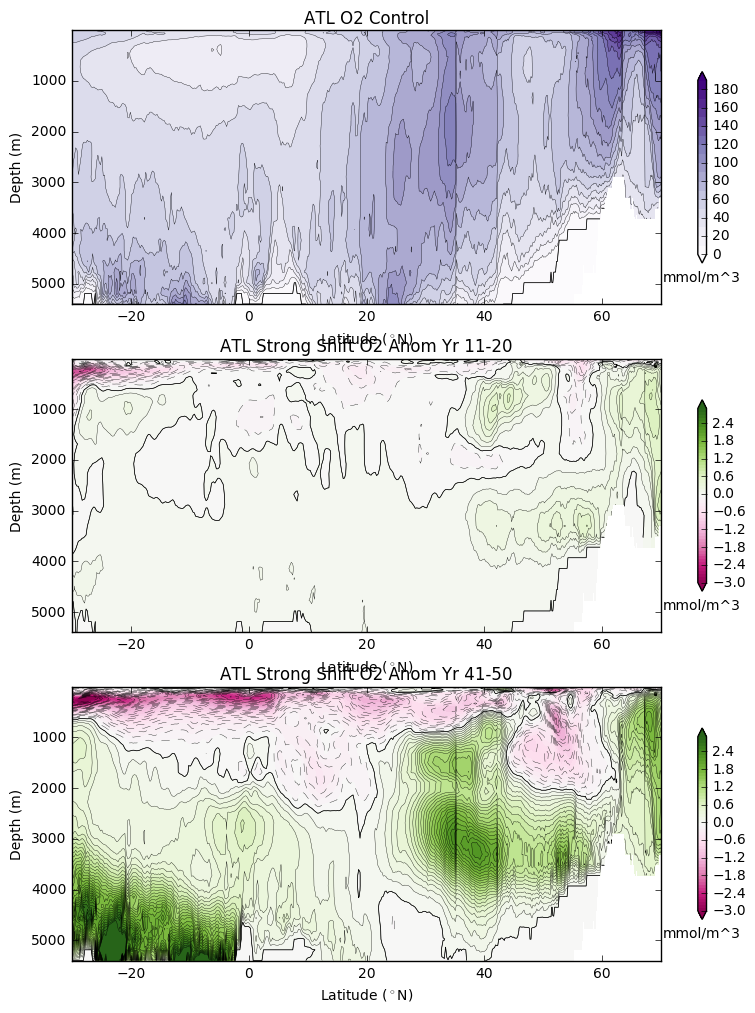

In [31]:
#zonal average O2 and anomaly
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=480
t2=600

clev = np.arange(0,200,10)

plt.subplot(311)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_o2[t1:t2,:,:],axis=0),cmap=plt.cm.Purples,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL O2 Control')

clev = np.arange(-3,3,.1)
t1=120
t2=240

plt.subplot(312)
plt.contourf(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL Strong Shift O2 Anom Yr 11-20')

clev = np.arange(-3,3,.1)
t1=480
t2=600

plt.subplot(313)
plt.contourf(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pi_o2[t1:t2,:,:],axis=0)-np.mean(cntrl_o2[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL Strong Shift O2 Anom Yr 41-50')


(600,)
728.692077637
(600, 50, 1080)
(600, 1080)


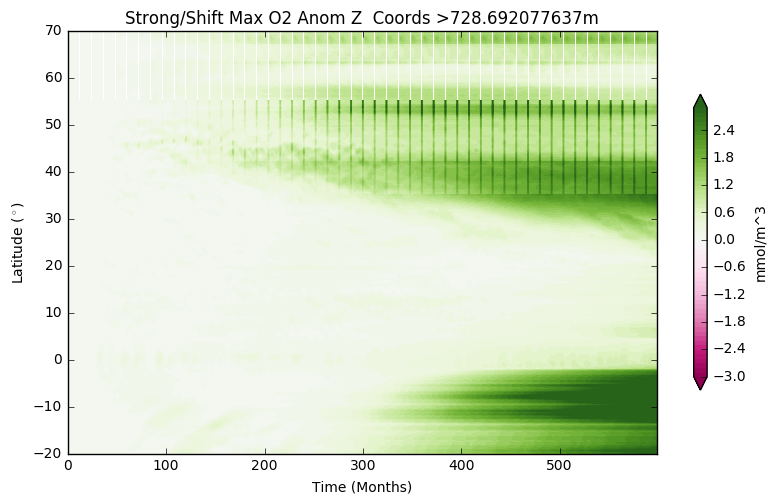

In [29]:
#Hovmoeller in z space of O2 anoms
time = np.arange(0,600,1)
print time.shape

st_min=25
print st_ocean[st_min]

pi_o2_anom= pi_o2[:,:,:] - cntrl_o2[:,:,:]
print pi_o2_anom.shape

pi_o2_anom_max = np.max(pi_o2_anom[:,st_min:,:],1)
print pi_o2_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-3,3,.1)
#print clev

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


plt.subplot(212)
plt.contourf(time,yu_ocean,pi_o2_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('mmol/m^3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
tit='Strong/Shift Max O2 Anom Z  Coords >' + str(st_ocean[st_min]) + 'm'
plt.title(tit)

In [13]:
print st_ocean[30]

1497.56188965


In [20]:
of=os.path.join(PIDir,'piwombat_Atl_zavgDIC.npy')
pi_dic=np.load(of)
print pi_dic.shape

of=os.path.join(CntrlDir,'cntrlwombat_Atl_zavgDIC.npy')
cntrl_dic=np.load(of)
print cntrl_dic.shape

(600, 50, 1080)
(600, 50, 1080)


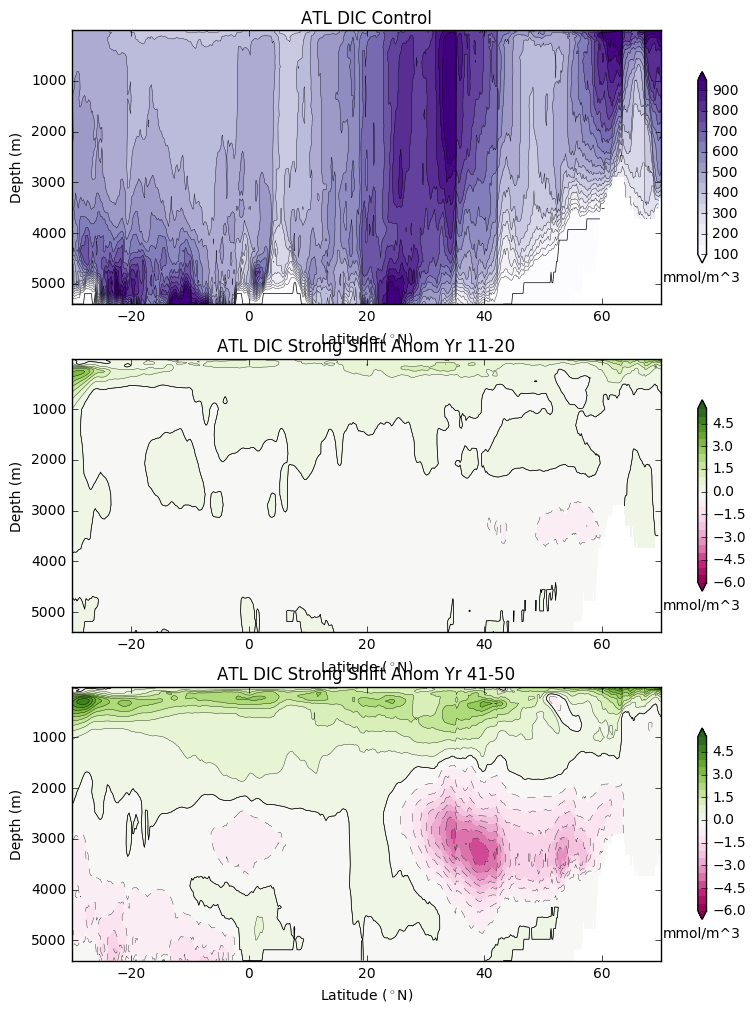

In [27]:
#zonal average DIC and anomaly
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=480
t2=600

clev = np.arange(100,1000,50)

plt.subplot(311)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_dic[t1:t2,:,:],axis=0),cmap=plt.cm.Purples,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL DIC Control')

clev = np.arange(-6,6,.5)
t1=120
t2=240

plt.subplot(312)
plt.contourf(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL DIC Strong Shift Anom Yr 11-20')

t1=480
t2=600
clev = np.arange(-6,6,.5)

plt.subplot(313)
plt.contourf(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('mmol/m^3')
plt.contour(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pi_dic[t1:t2,:,:],axis=0)-np.mean(cntrl_dic[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,70])
plt.title('ATL DIC Strong Shift Anom Yr 41-50')


(600,)
728.692077637
(600, 50, 1080)
(600, 1080)


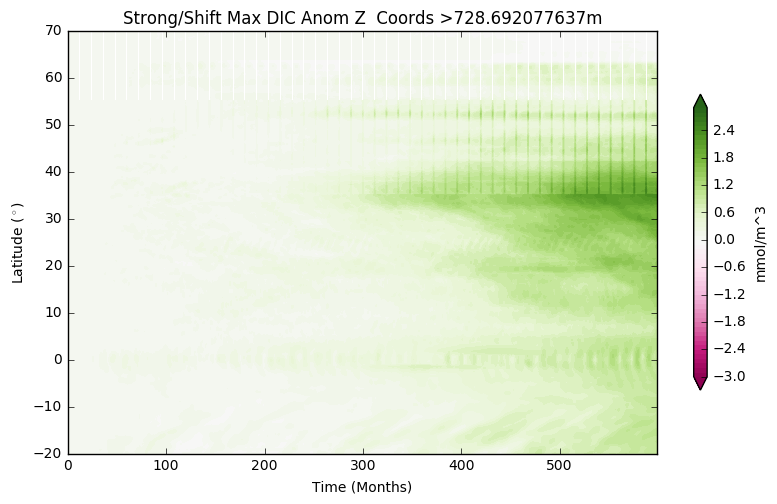

In [30]:
#Hovmoeller in z space of DIC anoms
time = np.arange(0,600,1)
print time.shape

st_min=25
print st_ocean[st_min]

pi_dic_anom= pi_dic[:,:,:] - cntrl_dic[:,:,:]
print pi_dic_anom.shape

pi_dic_anom_max = np.max(pi_dic_anom[:,st_min:,:],1)
print pi_dic_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-3,3,.1)
#print clev


plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


plt.subplot(212)
plt.contourf(time,yu_ocean,pi_dic_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('mmol/m^3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
plt.ylim([-20,70])
tit='Strong/Shift Max DIC Anom Z  Coords >' + str(st_ocean[st_min]) + 'm'
plt.title(tit)

In [14]:
#zonal average winds stress in Southern Ocean
Ocean_File = os.path.join(CntrlDir,'output*/ocean_force*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.tau_x.shape

cn=ff.tau_x[-12:,:,:].mean('Time').mean('xu_ocean').load()
print cn.shape

Ocean_File = os.path.join(PIDir,'output*/ocean_force*.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.tau_x.shape

pi=ff.tau_x[-12:,:,:].mean('Time').mean('xu_ocean').load()
print pi.shape




/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ocean_force*.nc
(600, 1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(1080,)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_force*.nc
(660, 1080, 1440)
(1080,)


/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ocean_force*.nc
(600, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ocean_force*.nc
(660, 1080, 1440)


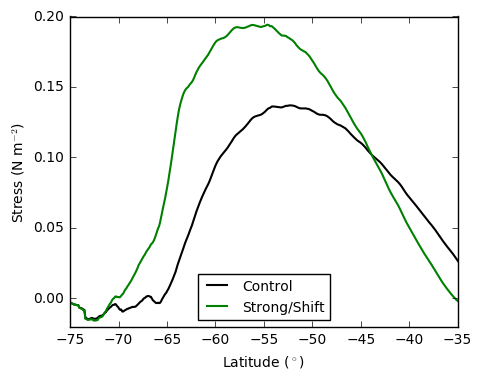

In [17]:
# Put all in this figure
cols = ['k','g']
lines = ['-','-',]
exp_names = ['cp','pi']
labels = ['Control','Strong/Shift']
plt.figure(figsize(5,4))

tx=np.zeros((2,1080))
ii=-1
for fn in ExpDirs:
    ii+=1
    
    filename = fn + 'output*/ocean_force*.nc' 
    
    print filename
    
    ff=xr.open_mfdataset(filename,engine='netcdf4',concat_dim='Time',decode_times=False)
    print ff.tau_x.shape

    tx[ii,:]=ff.tau_x[-12:,:,:].mean('Time').mean('xu_ocean').load()
    
    plt.plot(yu_ocean,tx[ii,:],linestyle=lines[ii],color=cols[ii],linewidth=1.5,label=labels[ii])

plt.xlim([-75,-35])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)
#plt.savefig('figures/WindStress.pdf')

/g/data1/v45/pas561/mom/input/u_10.nc
(1460, 94, 192)
/g/data1/v45/pas561/mom/input/u_10.30Sup15shift4.nc
(1460, 94, 192)
(94,)
(2, 94)


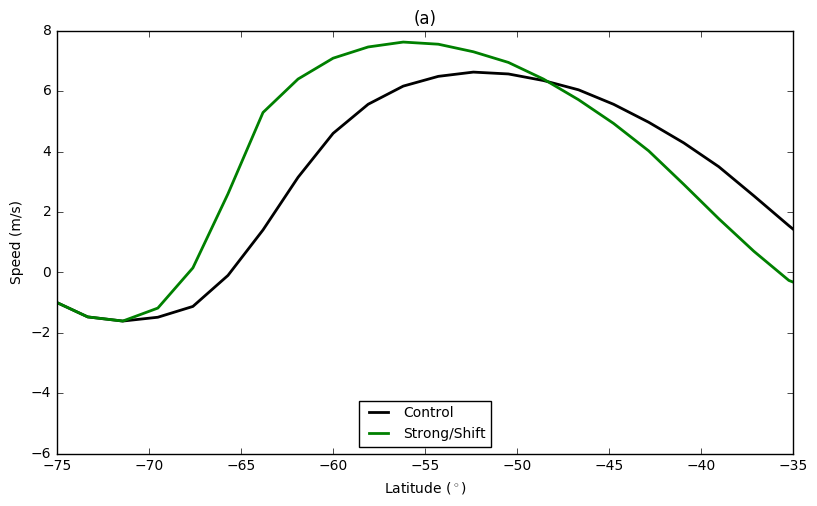

In [15]:
#zonal average winds speed in Southern Ocean
uwspd=np.zeros((2,94))


Ocean_File = os.path.join('/g/data1/v45/pas561/mom/input/u_10.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='TIME',decode_times=False)
print ff.U_10_MOD.shape
uwspd[0,:]=ff.U_10_MOD[:,:,:].mean('TIME').mean('LON').load()

Ocean_File = os.path.join('/g/data1/v45/pas561/mom/input/u_10.30Sup15shift4.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='TIME',decode_times=False)
print ff.U_10_MOD.shape
uwspd[1,:]=ff.U_10_MOD[:,:,:].mean('TIME').mean('LON').load()

uwspd_lat=ff.LAT.load()
print uwspd_lat.shape
print uwspd.shape

#plot wind speed
plt.subplot(211)
plt.plot(uwspd_lat,uwspd[0,:],linestyle='-',color='k',linewidth=2,label='Control')
plt.plot(uwspd_lat,uwspd[1,:],linestyle='-',color='g',linewidth=2,label='Strong/Shift')
plt.xlim([-75,-35])
#plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$)')
plt.ylabel('Speed (m/s)')
plt.legend(loc=8,fontsize=10)
plt.title('(a)')


In [19]:
#north atl mld, sea ice changes, surface and bottom velocity anomalies in Atl., density and carbon.

Ocean_File = os.path.join(CntrlDir,'output*/ocean__1*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
nyf_mld=ff.mld[-10:,:,:].mean('Time').load()
print nyf_mld.shape

Ocean_File = os.path.join(PIDir,'output*/ocean_month_*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
pi_mld=ff.mld.load()
print pi_mld.shape

(1080, 1440)
(50, 1080, 1440)


mld bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [ 30.13168517] 89.947282327


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/pandas/indexes/base.py:1428: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return promote(getitem(key))
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/xarray/core/indexing.py:478: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._ensure_ndarray(self.array[key])
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  dout = self.data[indx]
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/

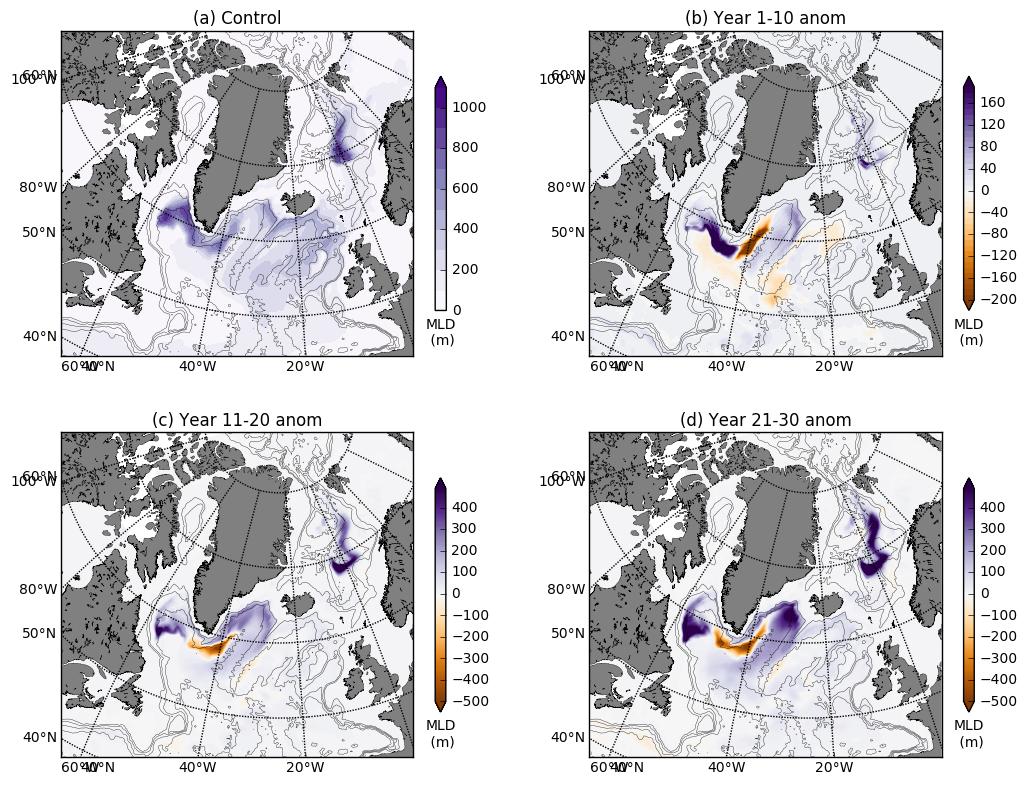

In [20]:
#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

print "mld bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

plt.subplot(221)#,axisbg='gray')
clev = np.arange(0,1200,100)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

clev = np.arange(-500,500,10)
clev2 = np.arange(-200,200,10)

plt.subplot(222)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pi_mld[0:9,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev2, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(b) Year 1-10 anom')
#plt.show()


plt.subplot(223)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pi_mld[10:19,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(c) Year 11-20 anom')
#plt.show()

plt.subplot(224)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pi_mld[20:29,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(d) Year 21-30 anom')
#plt.show()

plt.show()

#plt.subplot(221)
#print nyf_mld.shape

#clev = np.arange(0,1000,100)
#plt.contourf(geolon_t,geolat_t,nyf_mld[0],cmap=plt.cm.rainbow_r,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('m')
##clev = np.arange(-2,1,0.05)
##plt.hold()
#plt.contour(geolon_t,geolat_t,nyf_ssh[0],levels=clev,colors='k',linewidths=0.25)
#plt.ylabel('Latitude ($^\circ$)')
#plt.xlabel('Longitude ($^\circ$)')
#plt.ylim([40,80])
#plt.xlim([-100,50])
#plt.title('MLD with SSH contours')



In [21]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

3.59161e-06
4.91751e-09


In [22]:
Ocean_File = os.path.join(CntrlDir,'output*/ice__*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[0:119,:,:,:].mean('time').sum('ct').load()
print nyf_cn.shape

Ocean_File = os.path.join(PIDir,'output*/ice_month*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
pi_cn1=ff.CN[0:119,:,:,:].mean('time').sum('ct').load()
print pi_cn1.shape
pi_cn2=ff.CN[120:239,:,:,:].mean('time').sum('ct').load()
print pi_cn2.shape
pi_cn3=ff.CN[240:359,:,:,:].mean('time').sum('ct').load()
print pi_cn3.shape



(600, 5, 1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)


[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


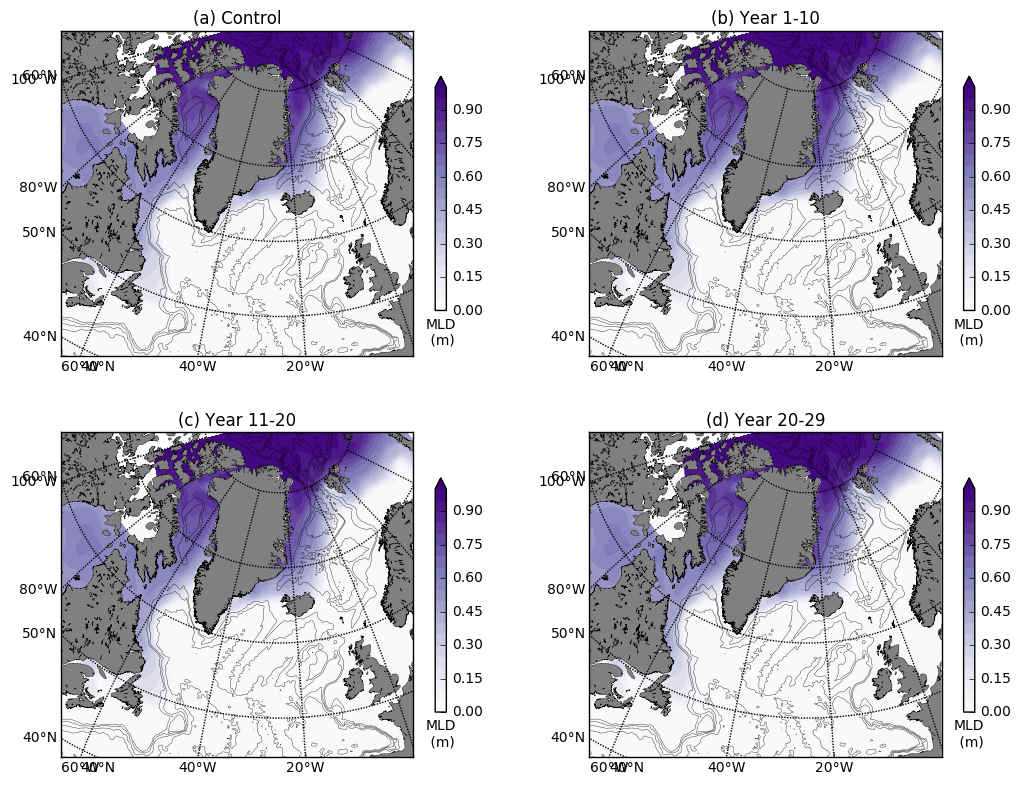

In [23]:
#plot NAtl Sea Ice 
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,21)
print clev

plt.subplot(221)#,axisbg='gray')
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,nyf_cn[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

plt.subplot(222)#,axisbg='gray')
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pi_cn1[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(b) Year 1-10')
#plt.show()

plt.subplot(223)#,axisbg='gray')
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pi_cn2[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(c) Year 11-20')
#plt.show()

plt.subplot(224)#,axisbg='gray')
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pi_cn3[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(d) Year 20-29')
#plt.show()

In [26]:
#plot near surface velocity anomaly vectors
#plot near surface velocity anomaly vectors
Ocean_File = os.path.join(CntrlDir,'output197*/ocean__1*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.u.shape
nyf_u=ff.u[:,0:31,:,:].mean('Time').load()
nyf_v=ff.v[:,0:31,:,:].mean('Time').load()
print nyf_u.shape

Ocean_File = os.path.join(PIDir,'output197*/ocean_month_*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.u.shape
up_u1a=ff.u[0:10,0:31,:,:].mean('Time').load()
up_v1a=ff.v[0:10,0:31,:,:].mean('Time').load()
print up_v1a.shape

Ocean_File = os.path.join(PIDir,'output198*/ocean_month_*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.u.shape
up_u1b=ff.u[0:10,0:31,:,:].mean('Time').load()
up_v1b=ff.v[0:10,0:31,:,:].mean('Time').load()
print up_v1b.shape

Ocean_File = os.path.join(PIDir,'output199*/ocean_month_*.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.u.shape
up_u2=ff.u[0:10,0:31,:,:].mean('Time').load()
up_v2=ff.v[0:10,0:31,:,:].mean('Time').load()
print up_u2.shape


(9, 50, 1080, 1440)
(31, 1080, 1440)
(9, 50, 1080, 1440)
(31, 1080, 1440)
(10, 50, 1080, 1440)
(31, 1080, 1440)
(10, 50, 1080, 1440)
(31, 1080, 1440)


(10, 50, 1080, 1440)
(31, 1080, 1440)


In [28]:
#smooth velocity data with a gaussian filter
#set sigma
s=2
#set window
w=7
#solve for truncation
t = (((w - 1)/2)-0.5)/s

#nyf_u_sm = scipy.ndimage.filters.gaussian_filter(nyf_u[10,:,:], s,truncate=t)
#print nyf_u_sm.shape
#nyf_v_sm = scipy.ndimage.filters.gaussian_filter(nyf_v[10,:,:], s,truncate=t)





In [29]:
print st_ocean[10]

110.096153259


(1080, 1440)
(1080, 1440)
1497.56188965


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(1080, 1440)
(1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(1080, 1440)
(1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:88: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:101: VisibleDeprecationWarning: converting an array with ndim > 0 to a

(1080, 1440)
(1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:102: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:114: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


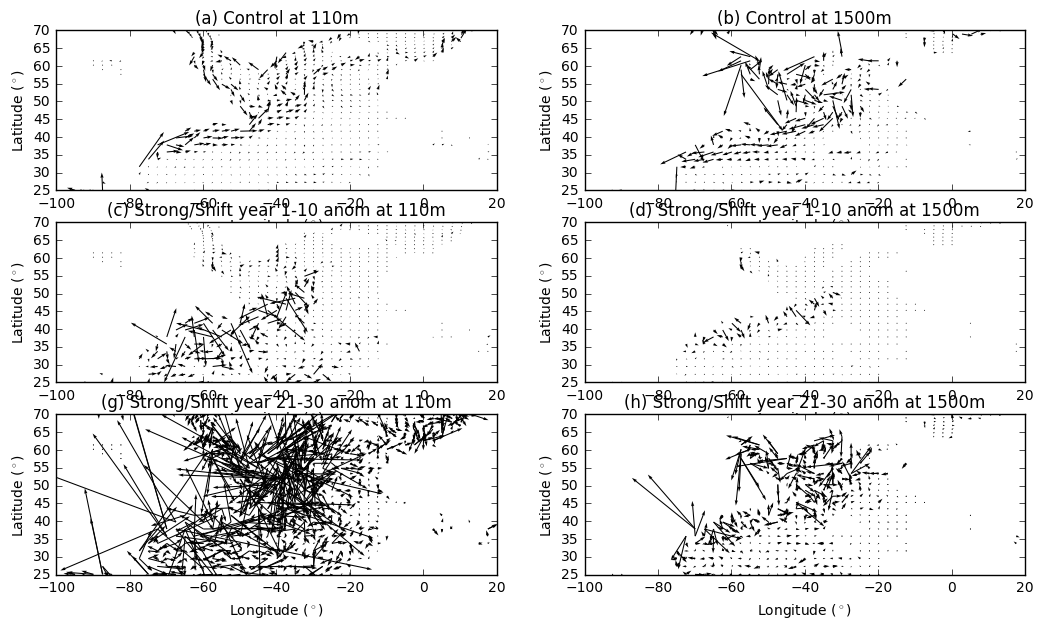

In [30]:
#plot NAtl velocity
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>20)# and lat<-45)
jj1=np.argwhere(yt_ocean>25)# and lat<-45)
jj2=np.argwhere(yt_ocean>70)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

spc=10

nyf_u_sm = scipy.ndimage.filters.gaussian_filter(nyf_u[10,:,:], s,truncate=t)
print nyf_u_sm.shape
nyf_v_sm = scipy.ndimage.filters.gaussian_filter(nyf_v[10,:,:], s,truncate=t)

plt.subplot(421)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],nyf_u_sm[jj1:jj2:spc,ii1:ii2:spc],
            nyf_v_sm[jj1:jj2:spc,ii1:ii2:spc],scale=1,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(a) Control at 110m')

nyf_u30_sm = scipy.ndimage.filters.gaussian_filter(nyf_u[30,:,:], s,truncate=t)
print nyf_u30_sm.shape
print st_ocean[30]
nyf_v30_sm = scipy.ndimage.filters.gaussian_filter(nyf_v[30,:,:], s,truncate=t)

plt.subplot(422)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],nyf_u30_sm[jj1:jj2:spc,ii1:ii2:spc],
            nyf_v30_sm[jj1:jj2:spc,ii1:ii2:spc],scale=0.1,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(b) Control at 1500m')

up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u1a[10,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v1a[10,:,:], s,truncate=t)

plt.subplot(423)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(c) Strong/Shift year 1-10 anom at 110m')

up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u1a[30,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v1a[30,:,:], s,truncate=t)

plt.subplot(424)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u30_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v30_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(d) Strong/Shift year 1-10 anom at 1500m')


up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u1b[10,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v1b[10,:,:], s,truncate=t)

plt.subplot(425)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(e) Strong/Shift year 11-20 anom at 110m')

up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u1b[30,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v1b[30,:,:], s,truncate=t)

plt.subplot(426)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u30_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v30_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(f) Strong/Shift year 11-20 anom at 1500m')

up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u2[10,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v2[10,:,:], s,truncate=t)

plt.subplot(425)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(g) Strong/Shift year 21-30 anom at 110m')

up_u_sm = scipy.ndimage.filters.gaussian_filter(up_u2[30,:,:], s,truncate=t)
print up_u_sm.shape
up_v_sm = scipy.ndimage.filters.gaussian_filter(up_v2[30,:,:], s,truncate=t)

plt.subplot(426)#,axisbg='gray')
plt.quiver(geolon_t[jj1:jj2:spc,ii1:ii2:spc],geolat_t[jj1:jj2:spc,ii1:ii2:spc],up_u_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_u30_sm[jj1:jj2:spc,ii1:ii2:spc],
            up_v_sm[jj1:jj2:spc,ii1:ii2:spc]-nyf_v30_sm[jj1:jj2:spc,ii1:ii2:spc],scale=.05,scale_units='inches')
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([25,70])
plt.xlim([-100,20])
plt.title('(h) Strong/Shift year 21-30 anom at 1500m')

plt.savefig('Wombat_PI3.pdf')



[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5]
/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ice__*.nc
(600, 1080, 1440)
(1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ice_month*.nc
(600, 1080, 1440)
(1080, 1440)


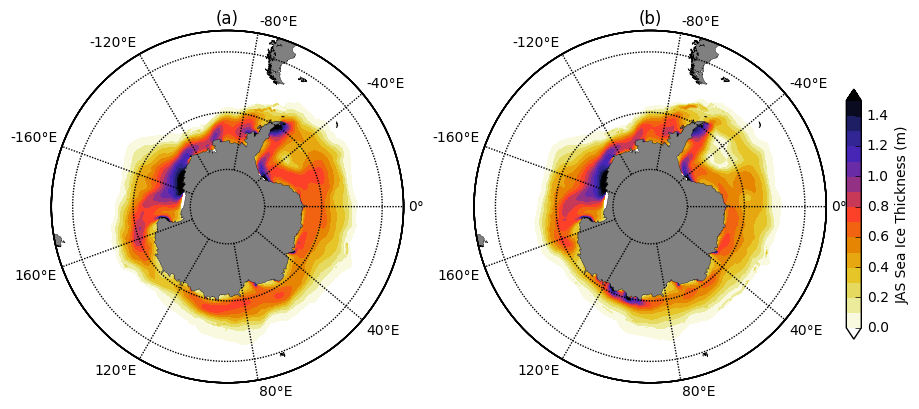

In [16]:
#Southern Ocean Sea Ice Thickness
labels = ['(a)','(b)','(c)','(d)']
plt.figure(figsize(10,10))

ii=-1
levels = np.linspace(0,1.5,16)
print levels


ii=-1
for fn in ExpDirs:
    ii+=1
    
    if ii==0:
        filename = fn + 'output*/ice__*.nc'
    if ii==1:
        filename = fn + 'output*/ice_month*.nc'
        
    
    print filename
    
    ff=xr.open_mfdataset(filename,engine='netcdf4',concat_dim='time',decode_times=False)
    print ff.HI.shape

    hi=ff.HI[6:8,:,:].mean('time').load()
    print hi.shape
    
    plt.subplot(1,2,ii+1)
    map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,hi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
    plt.title(labels[ii])


ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('JAS Sea Ice Thickness (m)')

#plt.savefig('figures/MLD.pdf')
#plt.savefig('figures/MLD.png',dpi=220)



[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
/g/data1/v45/pas561/mom/archive/wombat_jun16z/output*/ice__*.nc
(600, 5, 1080, 1440)
(2, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ice_month*.nc
(600, 5, 1080, 1440)
(2, 1080, 1440)


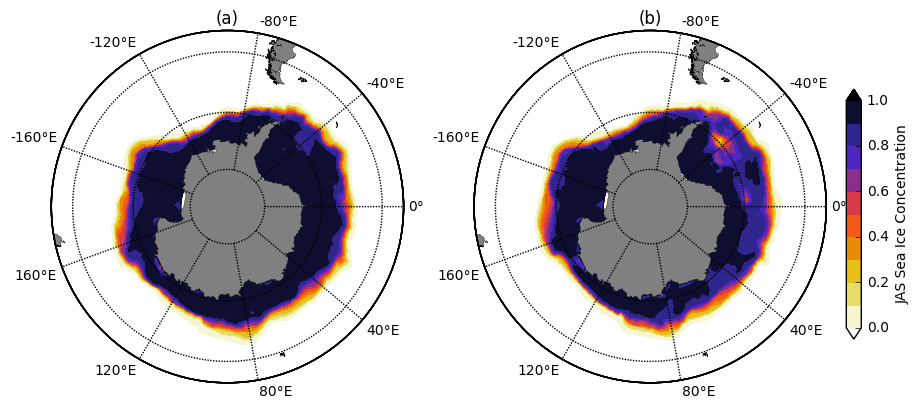

In [23]:
#Sea Ice Conc
labels = ['(a)','(b)','(c)','(d)']
plt.figure(figsize(10,10))

ii=-1
levels = np.linspace(0,1.0,11)
print levels


jas_cn=np.zeros((2,1080,1440))
ii=-1
for fn in ExpDirs:
    ii+=1
    
    if ii==0:
        filename = fn + 'output*/ice__*.nc'
    if ii==1:
        filename = fn + 'output*/ice_month*.nc'
        
    
    print filename
    
    ff=xr.open_mfdataset(filename,engine='netcdf4',concat_dim='time',decode_times=False)
    print ff.CN.shape

    #cn=ff.CN[:,:,:,:].sum('ct').load()
    #print cn.shape
    jas_cn[ii,:,:]=ff.CN[6:8,:,:,:].sum('ct').mean('time').load()
    print jas_cn.shape

    plt.subplot(1,2,ii+1)
    map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-80.,81.,15.))
    map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,jas_cn[ii,:,:], cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
    plt.title(labels[ii])


ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('JAS Sea Ice Concentration')

#plt.savefig('figures/MLD.pdf')
#plt.savefig('figures/MLD.png',dpi=220)



In [17]:
#Hov of Sea Ice Conc.
print xt_ocean[1040]
print xt_ocean[878]

filename = PIDir + 'output*/ice_month*.nc'
print filename
    
ff=xr.open_mfdataset(filename,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape

cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print cn.shape
    

-19.875
-60.375
/g/data1/v45/pas561/mom/archive/wombat_jun16z_PI/output*/ice_month*.nc
(600, 5, 1080, 1440)
(600, 1080)


In [18]:
filename = CntrlDir + 'output1971/ice__*.nc'
print filename

ff=xr.open_mfdataset(filename,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape

cn1=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print cn1.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z/output1971/ice__*.nc
(12, 5, 1080, 1440)
(12, 1080)


In [19]:
print cn.shape
print cn1.shape
cn = np.concatenate((cn1,cn),axis=0)
print cn.shape

(600, 1080)
(12, 1080)
(612, 1080)


In [20]:
yt=ff.yt.load()
print yt.shape
time=ff.time.load()
print time.shape
time = np.arange(-12,600,1)
#print time
print time.shape

(1080,)
(12,)
(612,)


-19.875
-60.375
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5]


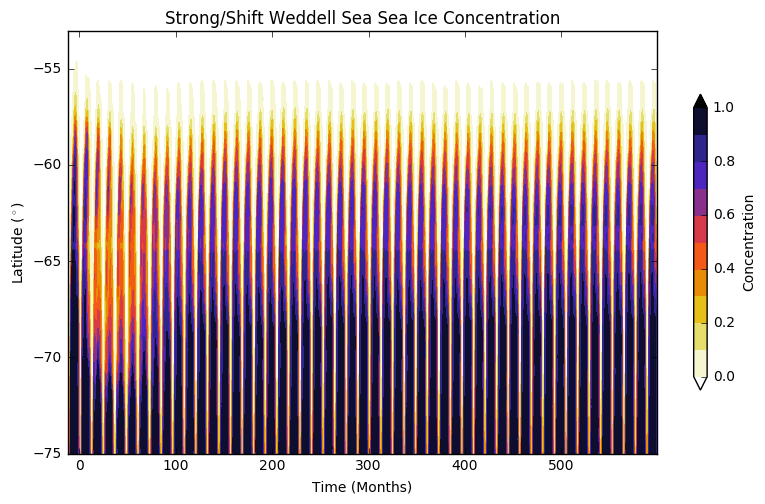

In [21]:
print xt_ocean[1040]
print xt_ocean[878]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,11)
print levels

plt.subplot(211)
plt.contourf(time,yt,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('Strong/Shift Weddell Sea Sea Ice Concentration')

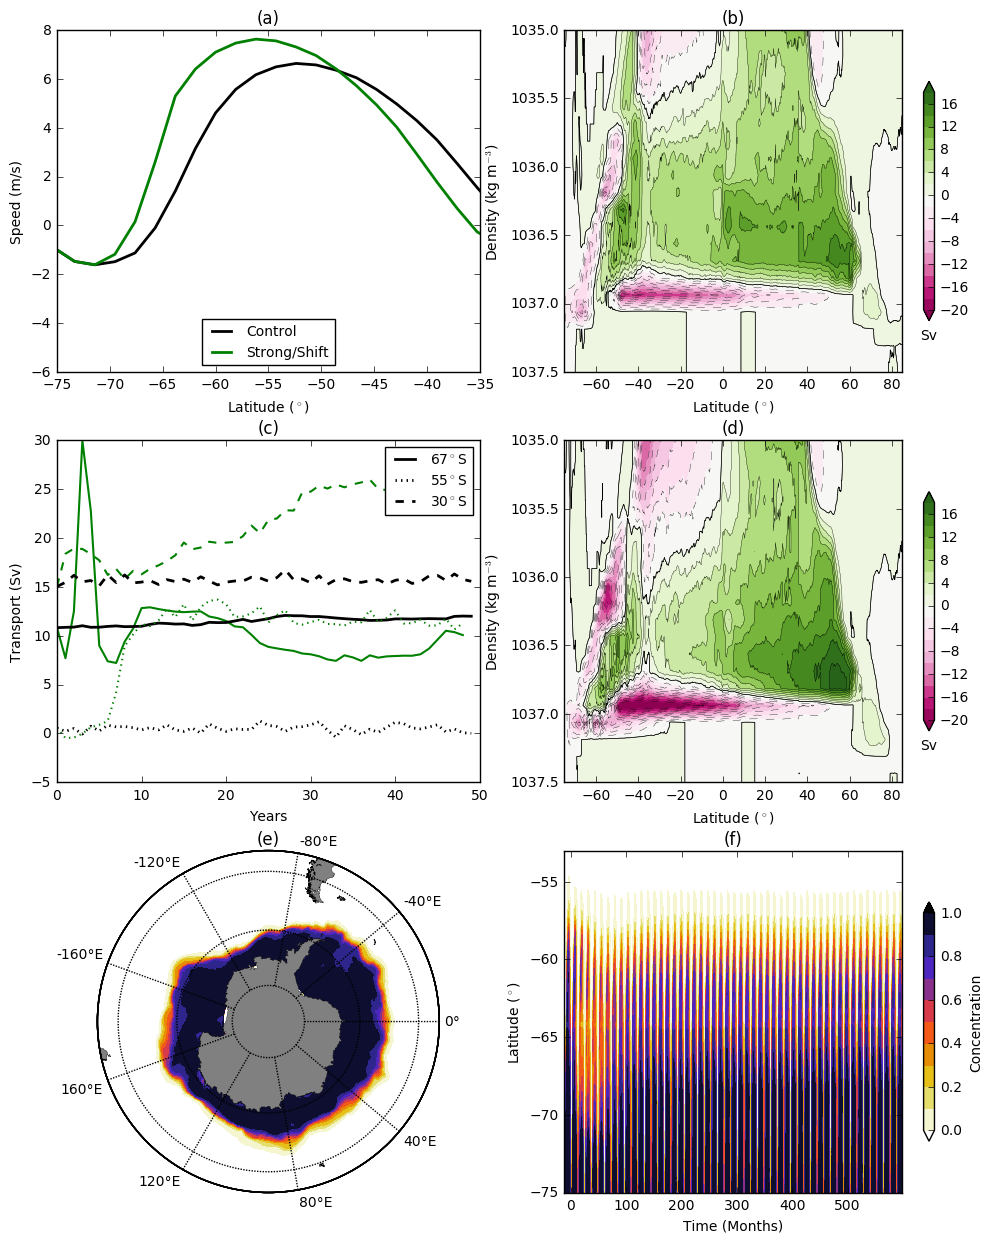

In [24]:
#final figure panels
plt.figure(figsize(12,15))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


#plot wind stress
#plt.subplot(321)
#plt.plot(yu_ocean,tx[0,:],linestyle='-',color='k',linewidth=2,label='Control')
#plt.plot(yu_ocean,tx[1,:],linestyle='-',color='g',linewidth=2,label='Strong/Shift')
#plt.xlim([-75,-35])
#plt.ylim([-0.02,0.2])
#plt.xlabel('Latitude ($^\circ$)')
#plt.ylabel('Stress (N m$^{-2}$)')
#plt.legend(loc=8,fontsize=10)
#plt.title('(a)')

#plot wind speed
plt.subplot(321)
plt.plot(uwspd_lat,uwspd[0,:],linestyle='-',color='k',linewidth=2,label='Control')
plt.plot(uwspd_lat,uwspd[1,:],linestyle='-',color='g',linewidth=2,label='Strong/Shift')
plt.xlim([-75,-35])
#plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$)')
plt.ylabel('Speed (m/s)')
plt.legend(loc=8,fontsize=10)
plt.title('(a)')

#plot MOC
clev = np.arange(-20,20,2)
plt.subplot(322)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,85])
plt.title('(b)')

#plot time series of AABW
plt.subplot(323)
plt.plot(pi67_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl67_psj_ts,linestyle='-',color='k',label='67$^\circ$S',linewidth=2)
plt.plot(pi55_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl55_psj_ts,linestyle=':',color='k',label='55$^\circ$S',linewidth=2)
plt.plot(pi30_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl30_psj_ts,linestyle='--',color='k',label='30$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('(c)')
plt.legend(fontsize=10)

plt.subplot(324)
plt.contourf(yu_ocean,potrho,np.mean(pi_gmoc[45:49,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[45:49,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[45:49,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,85])
plt.title('(d)')

clev = np.linspace(0,1.0,11)

plt.subplot(325)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,jas_cn[0,:,:], cmap=plt.cm.CMRmap_r, levels=clev, extend='both') #CMRmap_r, gist_stern_r
plt.title('(e)')
#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('Sv')


plt.subplot(326)
plt.contourf(time,yt,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('(f)')

plt.savefig('Wombat_PI.pdf')
#plt.savefig('Wombat_PI.png',dpi=3000)


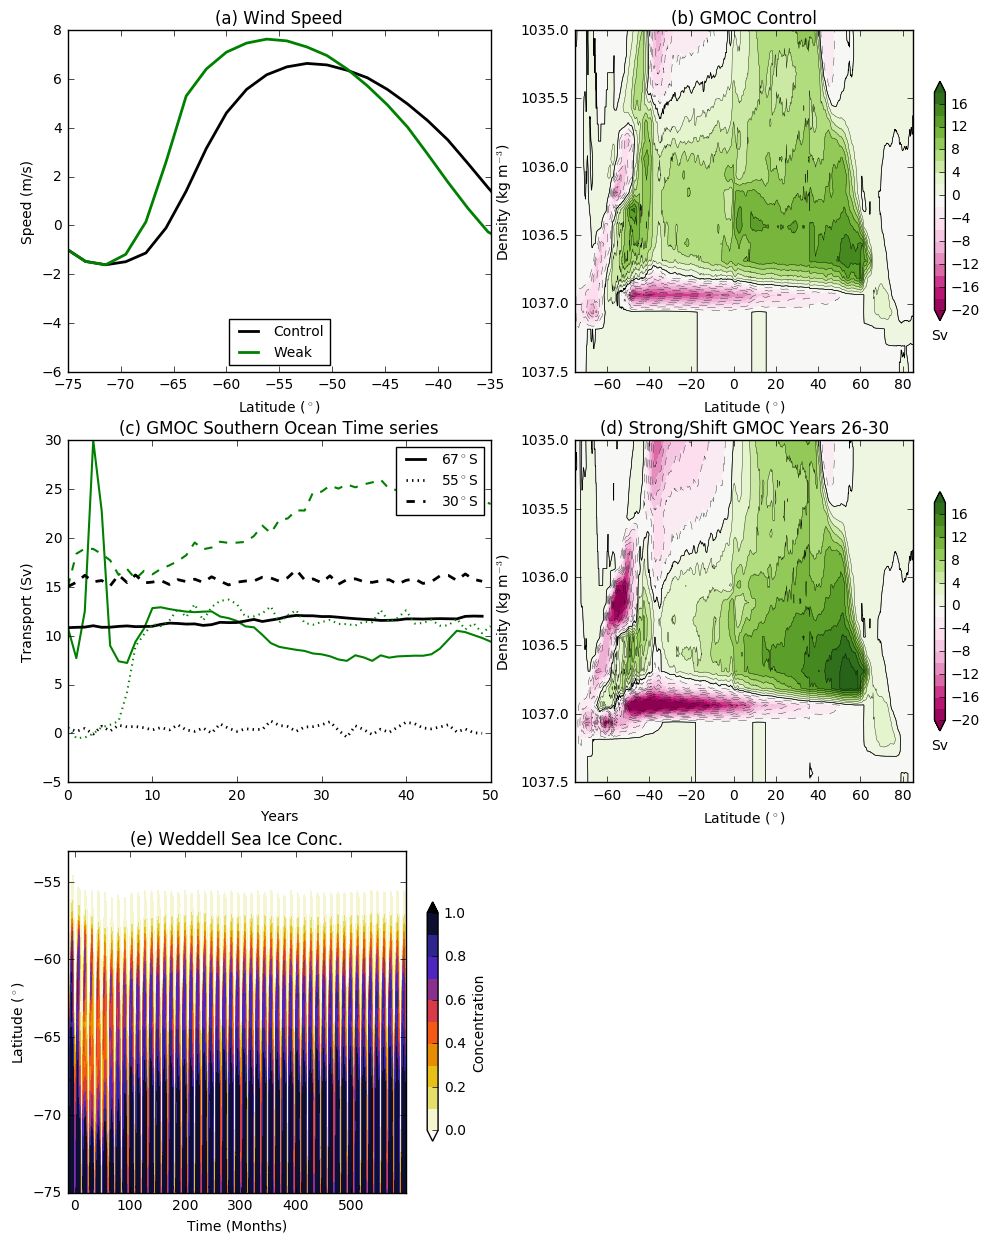

In [40]:
#final figure panels
plt.figure(figsize(12,15))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)


#plot wind stress
#plt.subplot(321)
#plt.plot(yu_ocean,tx[0,:],linestyle='-',color='k',linewidth=2,label='Control')
#plt.plot(yu_ocean,tx[1,:],linestyle='-',color='g',linewidth=2,label='Strong/Shift')
#plt.xlim([-75,-35])
#plt.ylim([-0.02,0.2])
#plt.xlabel('Latitude ($^\circ$)')
#plt.ylabel('Stress (N m$^{-2}$)')
#plt.legend(loc=8,fontsize=10)
#plt.title('(a)')

#plot wind speed
plt.subplot(321)
plt.plot(uwspd_lat,uwspd[0,:],linestyle='-',color='k',linewidth=2,label='Control')
plt.plot(uwspd_lat,uwspd[1,:],linestyle='-',color='g',linewidth=2,label='Weak')
plt.xlim([-75,-35])
#plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$)')
plt.ylabel('Speed (m/s)')
plt.legend(loc=8,fontsize=10)
plt.title('(a) Wind Speed')

#plot MOC
clev = np.arange(-20,20,2)
plt.subplot(322)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,85])
plt.title('(b) GMOC Control')

#plot time series of AABW
plt.subplot(323)
plt.plot(pi67_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(cntrl67_psj_ts,linestyle='-',color='k',label='67$^\circ$S',linewidth=2)
plt.plot(pi55_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(cntrl55_psj_ts,linestyle=':',color='k',label='55$^\circ$S',linewidth=2)
plt.plot(pi30_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(cntrl30_psj_ts,linestyle='--',color='k',label='30$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('(c) GMOC Southern Ocean Time series')
plt.legend(fontsize=10)

plt.subplot(324)
plt.contourf(yu_ocean,potrho,np.mean(pi_gmoc[26:30,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[26:30,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pi_gmoc[26:30,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,85])
plt.title('(d) Strong/Shift GMOC Years 26-30')

#
#map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
#map.drawcoastlines(linewidth=0.25)
#map.fillcontinents(color='gray',lake_color='gray')
## draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,15.))
#map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
#X, Y = map(geolon_t,geolat_t) 
#p1=map.contourf(X,Y,jas_cn[0,:,:], cmap=plt.cm.CMRmap_r, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#plt.title('(e)')
#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('Sv')

clev = np.linspace(0,1.0,11)
plt.subplot(325)
plt.contourf(time,yt,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('(e) Weddell Sea Ice Conc.')


plt.savefig('Wombat_PI1.pdf')

/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:66: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:85: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 1080)
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]


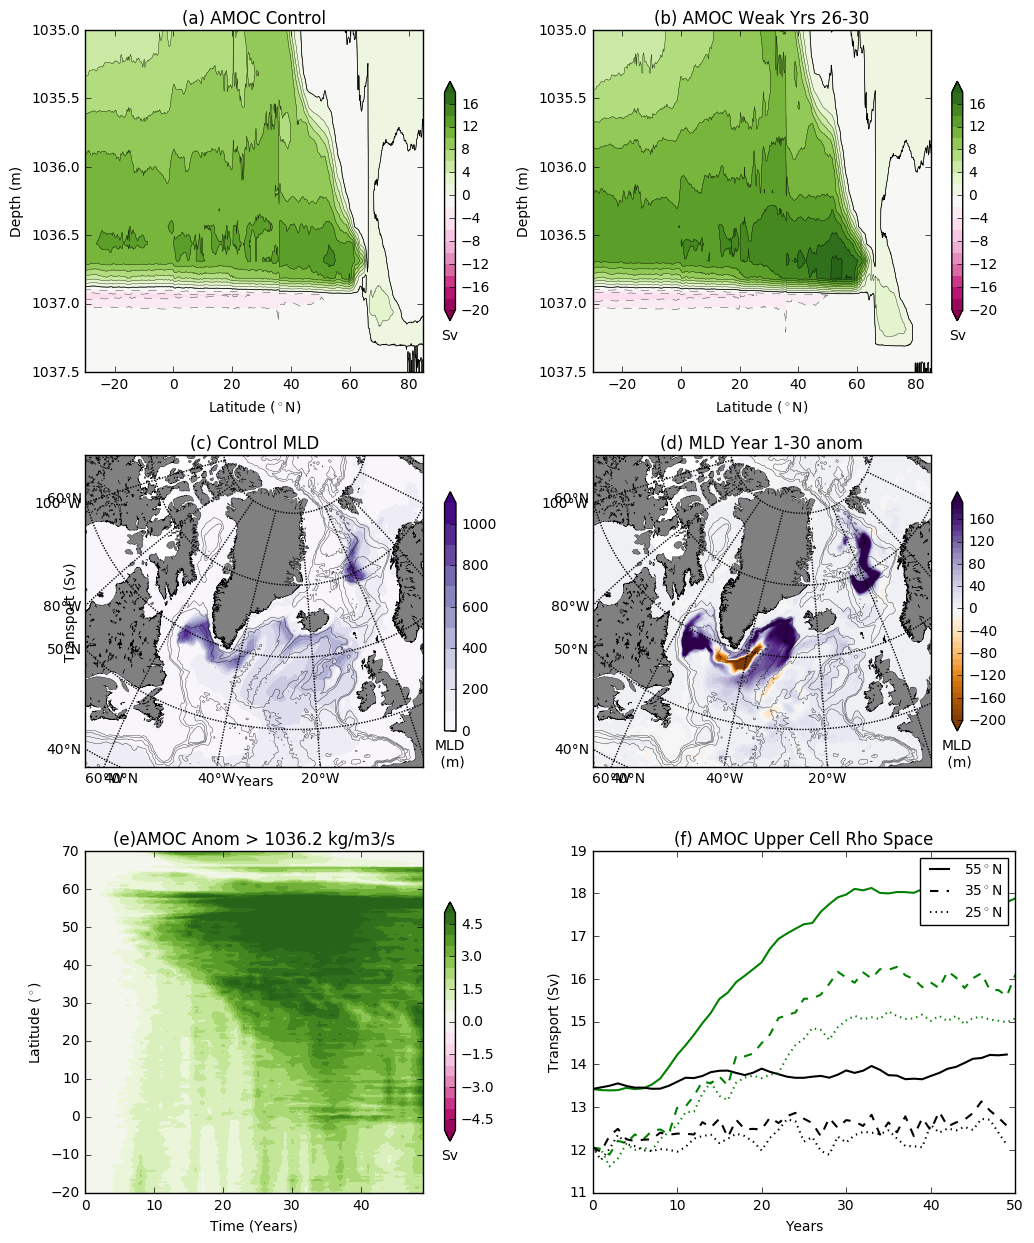

In [43]:
#final figure panels
plt.figure(figsize(12,15))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,20,2)

t1=26
t2=30

plt.subplot(321)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('(a) AMOC Control')

plt.subplot(322)
plt.contourf(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pi_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
plt.title('(b) AMOC Weak Yrs 26-30')


plt.subplot(323)
plt.plot(rho_pi55N_psj_ts[0:49],linestyle='-',color='g',linewidth=1.5)
plt.plot(rho_cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(rho_pi35N_psj_ts[0:49],linestyle='--',color='g',linewidth=1.5)
plt.plot(rho_cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(rho_pi25N_psj_ts[0:49],linestyle=':',color='g',linewidth=1.5)
plt.plot(rho_cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('(c) AMOC Upper Cell Rho Space')

#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

plt.subplot(323)#,axisbg='gray')
clev = np.arange(0,1200,100)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(c) Control MLD')
#plt.show()

clev = np.arange(-200,200,10)
#clev2 = np.arange(-200,200,10)

plt.subplot(324)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pi_mld[0:30,jj1:jj2,ii1:ii2],axis=0)-nyf_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(d) MLD Year 1-30 anom')
#plt.show()

pi_amoc_rho_anom_max = np.max(pi_amoc_rho_anom[:,st_min:,:],1)
print pi_amoc_rho_anom_max.shape

clev = np.linspace(-5,5,21)
print clev
time = np.arange(0,50,1)

plt.subplot(325)
plt.contourf(time,yu_ocean,pi_amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
plt.title('(e)AMOC Anom > 1036.2 kg/m3/s')


plt.subplot(326)
plt.plot(rho_pi55N_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(rho_cntrl55N_psj_ts,linestyle='-',color='k',label='55$^\circ$N',linewidth=1.5)
plt.plot(rho_pi35N_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(rho_cntrl35N_psj_ts,linestyle='--',color='k',label='35$^\circ$N',linewidth=1.5)
plt.plot(rho_pi25N_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(rho_cntrl25N_psj_ts,linestyle=':',color='k',label='25$^\circ$N',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('(f) AMOC Upper Cell Rho Space')
plt.legend(fontsize=10)

plt.savefig('Wombat_PI2.pdf')
#plt.savefig('Wombat_PI.png',dpi=3000)

In [ ]:
#plot annual mean surface temp from last year of MOM runs

plt.subplot(3,2,1)
clev = np.arange(-2,34,1)
plt.contourf(geolon_t,geolat_t,woa_sst_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.xlabel('Longitude ($^\circ$W)')
plt.ylabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on MOM01 Grid')

ii=0
for e in expts:
        
    #plot full SST
    plt.subplot(3,2,ii+2)
    clev = np.arange(-2,34,1)
    plt.contourf(geolon_t,geolat_t,sst[ii,:,:],levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    cb.ax.set_xlabel('($^\circ$C)')
    plt.xlabel('Longitude ($^\circ$W)')
    plt.ylabel('Latitude ($^\circ$N)')
    plt.title(e)
    
    ii+=1
    print ii,e

plt.savefig('mom01_sst.pdf')

In [ ]:
#plot SST anomalies relative to WOA obs data on model grid

ii=0
for e in expts:
        
    #plot full SST
    plt.subplot(2,2,ii+1)
    clev = np.arange(-3,3,.2)
    plt.contourf(geolon_t,geolat_t,sst[ii,:,:]-woa_sst_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    cb.ax.set_xlabel('($^\circ$C)')
    plt.xlabel('Longitude ($^\circ$W)')
    plt.ylabel('Latitude ($^\circ$N)')
    plt.title(e+ " minus WOA")
    
    ii+=1
    print e
    
plt.savefig('mom01_sstanom.pdf')

In [ ]:
#plot annual mean zonal average temp from last year of MOM runs and WOA
plt.subplot(3,2,1)
clev = np.arange(-2,34,1)
plt.contourf(yt_ocean,ff.st_ocean,woa_zavg75_interp,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('($^\circ$C)')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.title('WOA Temp on KDS75 Grid')
    

ii=0
for e in expts:
    
    if e=="GFDL50":
        plt.subplot(3,2,ii+2)
        clev = np.arange(-2,34,1)
        plt.contourf(yt_ocean,st50_ocean,zavg50[ii,:,:],levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)

    else:
        plt.subplot(3,2,ii+2)
        clev = np.arange(-2,34,1)
        plt.contourf(yt_ocean,st75_ocean,zavg75[ii-1,:,:],levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)
    
    ii+=1
plt.savefig('mom01_zavT.pdf')

In [ ]:
#plot zonal average anomaly relative to WOA
ii=0
for e in expts:
    
    if e=="GFDL50":
        plt.subplot(2,2,ii+1)
        clev = np.arange(-1,1,.1)
        plt.contourf(yt_ocean,st50_ocean,zavg50[ii,:,:]-woa_zavg50_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)

    else:
        plt.subplot(2,2,ii+1)
        clev = np.arange(-1,1,.1)
        plt.contourf(yt_ocean,st75_ocean,zavg75[ii-1,:,:]-woa_zavg75_interp,cmap=plt.cm.PiYG,levels=clev,extend='both')
        cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        cb.ax.set_xlabel('($^\circ$C)')
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Latitude ($^\circ$N)')
        plt.title(e)
    
    ii+=1
plt.savefig('mom01_zavgTanom.pdf')

In [44]:
print st_ocean[40]

3508.63305664
